# Proizvodnja i potrošnja el. energije

Potrošnja električne energije je posmatrana sa dva aspekta:
Prvobitni podaci su prikupljeni sa stranice ENTSO-e za 2016., 2017. i 2018. godinu, te je uključen i dodatni fajl koji je dobijen od NOS BiH, a koji uključuje podatke o konzumu i gubicima za 2019., 2020. i 2021. godinu. Ovaj dio čini DIO A. DIO B je dobijen automatizacijom skidanja podataka sa stranice NOS BiH https://www.nosbih.ba/bs/ees/graf-potrosnje/ i pored potrošnje, sadrži i podatke o proizvodnji, te planiranoj potrošnji i proizvodnji za 2020. i 2021. godinu. Podaci za 2019. godinu nisu dostupni, kao i za neke dane u 2020. i 2021. godini.

## DIO A

### Podaci za 2016., 2017., 2018.

Dio satnih podataka potrošnje električne energije je pronađen na web-stranici https://www.entsoe.eu/. Ovi podaci su spašeni u fajlu "MHLV_data-2015-2017.xlsx") i sastoji se od dva lista, gdje se prvi odnosi na godine 2016,2017, a drugi list na 2018. i djelimično 2019. Fajl sadrži podatke za više država, te je prvo potrebno uraditi filtriranje podataka sa kodom "BA" koji se odnosi na Bosnu i Hercegovinu. U ovom fajlu nisu navedeni gubici, ali su se vrijednosti nasumično upoređivale sa fajlom dostavljenim iz NOSBiH, te se na osnovu toga zaključilo da su gubici već oduzeti od ukupne snage konzuma.

In [197]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt

In [198]:
file=pd.read_excel(r"FILES\ELEKT\MHLV_data-2015-2017.xlsx",header=0,sheet_name=1)
file2=pd.read_excel(r"FILES\ELEKT\MHLV_data-2015-2017.xlsx",header=0,sheet_name=0)

In [199]:
def filter_countrycode(filename,name):
    return filename[filename["CountryCode"]==name]

In [200]:
BA_file=filter_countrycode(file,"BA") #2018,2019
BA_file2=filter_countrycode(file2,"BA") # 2016,2017

U oba fajla su napravljene nove kolone koje sadržavaju: godinu, sat, mjesec, dan u godini i dan u sedmici. 

In [201]:
def assign_datetime(filename):
    filename=filename.assign(Godina=filename["DateUTC"].dt.year)
    filename=filename.assign(Sat=filename["DateUTC"].dt.hour)
    filename=filename.assign(Mjesec=filename["DateUTC"].dt.month)
    filename=filename.assign(Dan_u_godini=filename["DateUTC"].dt.dayofyear)
    filename=filename.assign(Dan_u_sedmici=filename["DateUTC"].dt.dayofweek)
    filename=filename.assign(Dan_u_mjesecu=filename["DateUTC"].dt.day)
    return filename

In [202]:
BA_file=assign_datetime(BA_file)
BA_file2=assign_datetime(BA_file2)

(600000.0, 1311807.5424999995)

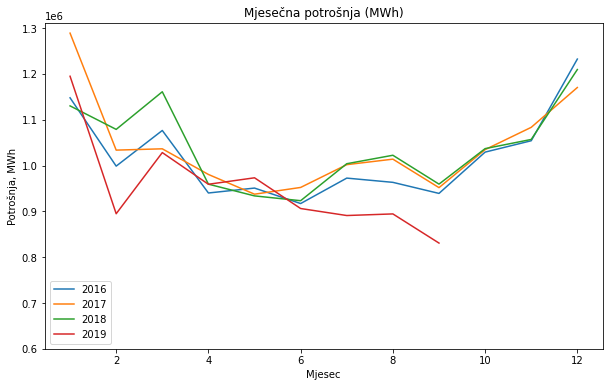

In [203]:
fig = plt.figure(figsize=(10,6))


BA_file2[BA_file2["Godina"]==2016].groupby("Mjesec")["Value"].sum().plot(label="2016")
BA_file2[BA_file2["Godina"]==2017].groupby("Mjesec")["Value"].sum().plot(label="2017")

BA_file[BA_file["Godina"]==2018].groupby("Mjesec")["Value"].sum().plot(label="2018")
BA_file[BA_file["Godina"]==2019].groupby("Mjesec")["Value"].sum().plot(label="2019")
plt.legend()
plt.xlabel("Mjesec")
plt.ylabel("Potrošnja, MWh")
plt.title("Mjesečna potrošnja (MWh)")
plt.ylim(bottom=600000)

### Podaci za 2018., 2019., 2020.  i obrada za dalju analizu

Nezavisni operator sistema (NOS BiH) je ustupio podatke o potrošnji el. energije za 2018., 2019. i 2020. godinu, uz satne gubitke električne energije.  S obzirom da ovi fajlovi sadrže i gubitke i da su podaci za 2019. potpuni, za 2018. i 2019. se neće koristiti podaci od entso-e, već podaci dobiveni od NOS BiH. Ovi podaci su spašeni u fajlu "Konzum 01.18-12.20.xlsx" u tri različita lista. Pošto kolona "Datum" nije u punom vremenskom formatu (sat dat u obliku 00-01), potrebno je prvo izvršiti pretvaranje u vremenski format kako bi podaci bili uporedivi sa onim dostupnim iz prethodnih koraka. 

In [204]:
file3_2018=pd.read_excel(r"FILES\ELEKT\Konzum 01.18-12.20.xlsx",header=(0,1),sheet_name=0)
file3_2019=pd.read_excel(r"FILES\ELEKT\Konzum 01.18-12.20.xlsx",header=(0,1),sheet_name=1)
file3_2020=pd.read_excel(r"FILES\ELEKT\Konzum 01.18-12.20.xlsx",header=(0,1),sheet_name=2)

In [205]:
file3_2018.columns

MultiIndex([(           'Datum', 'Unnamed: 0_level_1'),
            (          'Konzum',                'kWh'),
            (          'Gubici',                'MWh'),
            (          'Gubici',              'MWh.1'),
            ('Gubici + Konzum ',                'kWh')],
           )

In [206]:
new_columns=["Datum", "Konzum, kWh","Gubici, MWh", "Gubici, MWh.1","Gubici + Konzum, kWh"]
file3_2018.columns=new_columns
file3_2019.columns=new_columns
file3_2020.columns=new_columns
file3_2020.head(2)

,Datum,"Konzum, kWh","Gubici, MWh","Gubici, MWh.1","Gubici + Konzum, kWh"
0,01.01.2020 00-01,1208647,37.379,NaN,1246026
1,01.01.2020 01-02,1144023,39.612,NaN,1183635


In [207]:
hours=BA_file2[BA_file2["Godina"]==2017]["Sat"].values  #2017 ima isti broj sati, dana kao i 2018. i 2019.
days=BA_file2[BA_file2["Godina"]==2017]["Dan_u_godini"].values
months=BA_file2[BA_file2["Godina"]==2017]["Mjesec"].values
year=2018

hours_16=BA_file2[BA_file2["Godina"]==2016]["Sat"].values #2020. i 2016. su prestupne godine pa imaju isti broj sati i dana
days_16=BA_file2[BA_file2["Godina"]==2016]["Dan_u_godini"].values
months_16=BA_file2[BA_file2["Godina"]==2016]["Mjesec"].values


In [208]:
file3_2018["Godina"]=year
file3_2019["Godina"]=2019
file3_2020["Godina"]=2020
file3_2018["Sat"],file3_2019["Sat"],file3_2020["Sat"]=hours,hours,hours_16
file3_2018["Mjesec"],file3_2019["Mjesec"],file3_2020["Mjesec"]=months,months,months_16
file3_2018["Dan_u_godini"],file3_2019["Dan_u_godini"],file3_2020["Dan_u_godini"]=days,days,days_16


dt1 = dt.date(2017,12,31)
dtdelta = [dt.timedelta(days=int(i)) for i in file3_2018["Dan_u_godini"].values]
aa=[None]*(len(file3_2018["Dan_u_godini"].values))
for i in range(len(dtdelta)):
    aa[i]=(dt1 + dtdelta[i])
file3_2018["Date"]=aa

dt1 = dt.date(2018,12,31)
dtdelta = [dt.timedelta(days=int(i)) for i in file3_2019["Dan_u_godini"].values]
aa=[None]*(len(file3_2019["Dan_u_godini"].values))
for i in range(len(dtdelta)):
    aa[i]=(dt1 + dtdelta[i])
file3_2019["Date"]=aa

dt1 = dt.date(2019,12,31)
dtdelta = [dt.timedelta(days=int(i)) for i in file3_2020["Dan_u_godini"].values]
aa=[None]*(len(file3_2020["Dan_u_godini"].values))
for i in range(len(dtdelta)):
    aa[i]=(dt1 + dtdelta[i])
file3_2020["Date"]=aa

In [209]:
file3_2018["Dan_u_sedmici"]=pd.to_datetime(file3_2018["Date"], errors='coerce').dt.dayofweek
file3_2019["Dan_u_sedmici"]=pd.to_datetime(file3_2019["Date"], errors='coerce').dt.dayofweek
file3_2020["Dan_u_sedmici"]=pd.to_datetime(file3_2020["Date"], errors='coerce').dt.dayofweek


file3_2018["Dan_u_mjesecu"]=pd.to_datetime(file3_2018["Date"], errors='coerce').dt.day
file3_2019["Dan_u_mjesecu"]=pd.to_datetime(file3_2019["Date"], errors='coerce').dt.day
file3_2020["Dan_u_mjesecu"]=pd.to_datetime(file3_2020["Date"], errors='coerce').dt.day

Navedeni podaci su dati u kWh, te ih je potrebno prebaciti u MWh

In [210]:
file3_2020["Gubici + Konzum, MWh"]=file3_2020["Gubici + Konzum, kWh"]/1000
file3_2018["Gubici + Konzum, MWh"]=file3_2018["Gubici + Konzum, kWh"]/1000
file3_2019["Gubici + Konzum, MWh"]=file3_2019["Gubici + Konzum, kWh"]/1000

file3_2020["Konzum, MWh"]=file3_2020["Konzum, kWh"]/1000
file3_2018["Konzum, MWh"]=file3_2018["Konzum, kWh"]/1000
file3_2019["Konzum, MWh"]=file3_2019["Konzum, kWh"]/1000

U drugoj polovini 2019. i 2020. je došlo do smanjenja preuzimanja električne energije iz prenosnog sistema radi izlaska iz pogona  tvornice Aluminij Mostar koji se desio 10. jula 2019. godine, te smanjenog rada PHE Čapljina u pumpnom režimu (96 GWh u 2019. godini na prema 137 GWh u 2018. godini). Poteškoće u poslovanju su imali i ostali veliki kupci, kao što su B.S.I. d.o.o. Jajce i R-S Silicon d.o.o Mrkonjić Grad, zbog nepovoljnih kretanja na globalnom tržištu metala izazvanih pandemijom bolesti COVID-19. Smanjenje mpotrošnje zabilježeno je kod svih kategorija kupaca priključenih na distributivni sistem, izuzev kod domaćinstava, najviše radi mjera usljed pandemije.  U 2020. godini pumpna hidroelektrana PHE Čapljina je iz prijenosnog sistema preuzela 113 GWh, a ukupna proizvodnje ove elektrane iznosila je 413 GWh električne energije.  Nezavisni proizvođači imaju značajan udio u proizvodnji iz manjih obnovljivih izvora (76,4%) dok je ostatak 23,6% proizveden u elektranama u vlasništvu elektroprivreda. U elektranama industrijskih proizvođača proizvedeno je 10,15 GWh. 

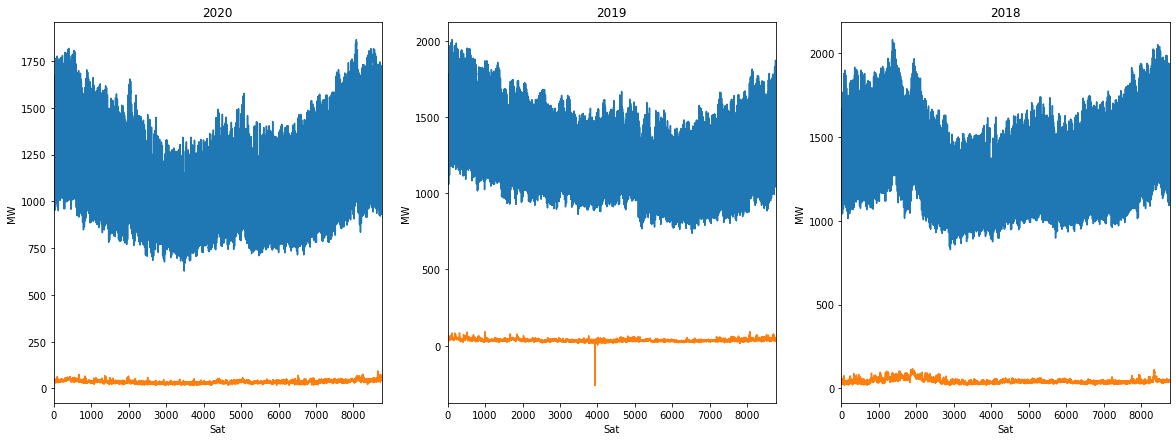

In [211]:
fig,ax = plt.subplots(ncols=3,figsize=(20,7))
ax[0].plot(np.arange(len(file3_2020)),file3_2020["Gubici + Konzum, MWh"], label="Potražnja")

ax[0].plot(np.arange(len(file3_2020)),file3_2020["Gubici, MWh"], label="Gubici")
ax[0].set_title("2020")

ax[0].set_xlabel("Sat")
ax[0].set_ylabel("MW")
ax[0].set_xlim(0,8760)


ax[1].plot(np.arange(len(file3_2019)),file3_2019["Gubici + Konzum, MWh"], label="Potražnja")
ax[1].plot(np.arange(len(file3_2019)),file3_2019["Gubici, MWh"], label="Gubici")
ax[1].set_title("2019")
ax[1].set_xlabel("Sat")
ax[1].set_ylabel("MW")
ax[1].set_xlim(0,8760)
#ax[1].legend()

ax[2].plot(np.arange(len(file3_2018)),file3_2018["Gubici + Konzum, MWh"], label="Potražnja")
ax[2].plot(np.arange(len(file3_2018)),file3_2018["Gubici, MWh"], label="Gubici")
ax[2].set_title("2018")
ax[2].set_xlabel("Sat")
ax[2].set_ylabel("MW")
ax[2].set_xlim(0,8760)
#ax[2].legend()
plt.show()


In [212]:
file3_2019[file3_2019["Gubici, MWh"]<0] #anomalija

,Datum,"Konzum, kWh","Gubici, MWh","Gubici, MWh.1","Gubici + Konzum, kWh",Godina,Sat,Mjesec,Dan_u_godini,Date,Dan_u_sedmici,Dan_u_mjesecu,"Gubici + Konzum, MWh","Konzum, MWh"
3934,13.06.2019 23-24,1170085.0,-261.476,NaN,908609.0,2019,22,6,164,2019-06-13,3,13,908.609,1170.085


Gubici u mreži mogu biti prenosni ili distributivni. Prenosni gubici iznosili su u 2020. godini iznosili 317,2 GWh, odnosno 1,75% od ukupne energije u preenosnom sistemu. 
Prenosni gubici su manji s obzirom da je u pitanju viši naponski nivo. Također, izborom višeg naponskog nivoa smanjuje se veličina provodnika i postiže se ušteda materijala i vrši se bolja regulacija napona. 
Izvještajem o radu DERK-a za 2019. i 2020.  je navedeno da je dugotrajni problem u elektronergetskom sistemu vrijednosti napona iznad vrijednosti propisanih Mrežnim kodeksom, naročito u 400 kV i 220 kV mreži. Glavni uzrok nastanka i trajanja previsokih napona su slabo opterećeni 400 kV dalekovodi u periodima niskog opterećenja konzuma, koji generiraju veliku količinu reaktivne energije. U pogledu rješenja, navodi se eventualna upotreba prigušnica.

Poremećaji u distributivnoj mreži su znatno nepovoljniji radi veće razgranatosti i veličine, te češće podliježu različitim vrstama kvarova.  Distiributivni gubici iznose cca 912,6 GWh ili 9,13% u odnosu na bruto distributivnu potrošnju i kontinuirano se smanjuju. U nastavku su dati dijagrami ukupnih gubitaka i potrošnje el.energije na godišnjem nivou. Vidljivo je da trend povećanja/smanjenja proizvodnje prati i trend povećanja/smanjenja gubitaka el. energije.

<AxesSubplot:title={'center':'2018 - Prenosni gubici, MWh'}, xlabel='Mjesec'>

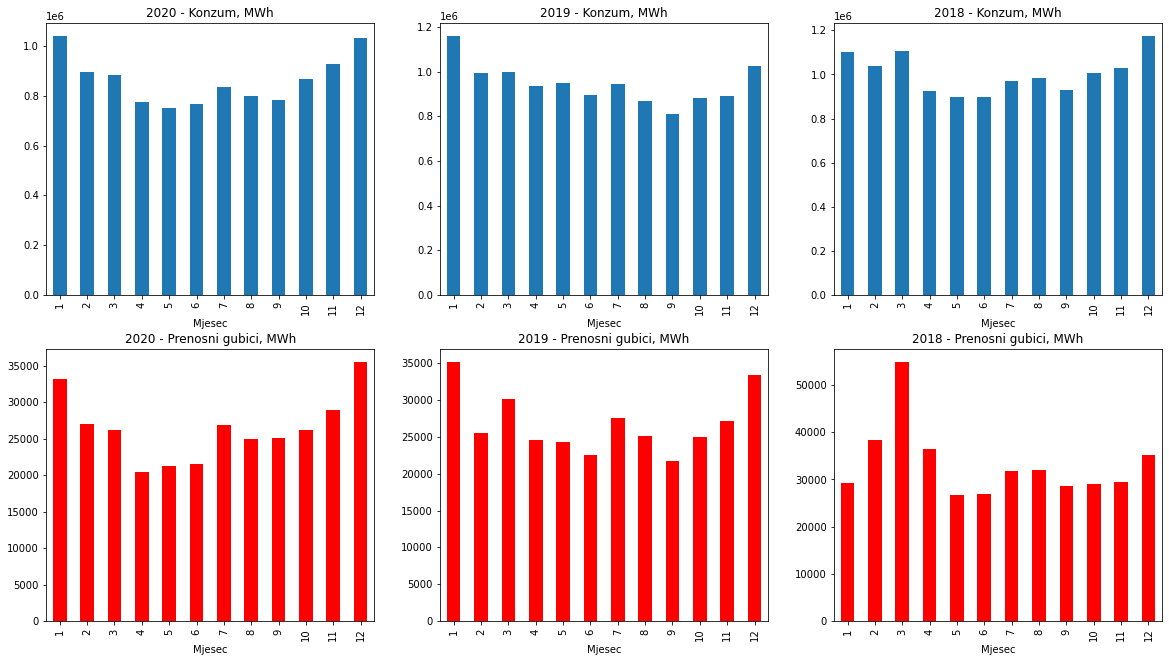

In [213]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,11))

"Gubici, MWh","Gubici + Konzum, MWh"

file3_2020.groupby("Mjesec").sum()["Konzum, MWh"].plot(kind="bar",ax=ax[0,0],title="2020 - Konzum, MWh")
file3_2019.groupby("Mjesec").sum()["Konzum, MWh"].plot(kind="bar",ax=ax[0,1],title="2019 - Konzum, MWh")
file3_2018.groupby("Mjesec").sum()["Konzum, MWh"].plot(kind="bar",ax=ax[0,2],title="2018 - Konzum, MWh")

file3_2020.groupby("Mjesec").sum()["Gubici, MWh"].plot(kind="bar",ax=ax[1,0],title="2020 - Prenosni gubici, MWh",color="red")
file3_2019.groupby("Mjesec").sum()["Gubici, MWh"].plot(kind="bar",ax=ax[1,1],title="2019 - Prenosni gubici, MWh",color="red")
file3_2018.groupby("Mjesec").sum()["Gubici, MWh"].plot(kind="bar",ax=ax[1,2],title="2018 - Prenosni gubici, MWh",color="red")



Potrošnja el. energije u zimskim nešto veća nego u ljetnim, čemu je vjerovatno uzrok što se određeni broj domaćinstava zimi koristi električnu energiju za grijanje prostora, s tim da se blagi porast javlja u 7. i 8. mjesecu, čemu je vjerovatno uzrok i korištenje uređaja za hlađenje prostora prilikom ekstremno visokih ljetnih temperatura. Minimalna potrošnja se obično javlja početkom maja (1. i 2.5.), dok je maksimalna potrošnja manje predvidiva, ali se u dva slučaja dešava na 31.12.

In [214]:
def find_min(file,name_col):
    minimum=file[name_col].min(axis=0)
    return file[file[name_col]==file[name_col].min()][["Mjesec","Dan_u_mjesecu","Sat"]],minimum
def find_max(file,name_col):
    maximum=file[name_col].max(axis=0)
    return file[file[name_col]==file[name_col].max()][["Mjesec","Dan_u_mjesecu","Sat"]],maximum

In [215]:
#Statistika
date,value=find_min(file3_2020,'Konzum, MWh')
print("Minimum u satu 2020. godine:",value,"MW")
date

Minimum u satu 2020. godine: 605.068 MW


,Mjesec,Dan_u_mjesecu,Sat
3482,5,25,2


In [216]:
date,value=find_min(file3_2019,'Konzum, MWh')
print("Minimum u satu 2019. godine:",value,"MW")
date

Minimum u satu 2019. godine: 714.2669999999999 MW


,Mjesec,Dan_u_mjesecu,Sat
6530,9,30,2


In [217]:
date,value=find_min(file3_2018,'Konzum, MWh')
print("Minimum u satu 2018. godine:",value,"MW")
date

Minimum u satu 2018. godine: 805.412 MW


,Mjesec,Dan_u_mjesecu,Sat
2906,5,2,2


In [218]:
date,value=find_min(BA_file2[BA_file2["Godina"]==2017],"Value")
print("Minimum u satu 2017. godine:",value,"MW")
date

Minimum u satu 2017. godine: 873.44 MW


,Mjesec,Dan_u_mjesecu,Sat
420822,5,2,1


In [219]:
#Statistika
date,value=find_min(BA_file2[BA_file2["Godina"]==2016],"Value")
print("Minimum u satu 2016. godine:",value,"MW")


Minimum u satu 2016. godine: 868.36 MW


In [220]:
#Statistika

date,value=find_max(file3_2020,'Konzum, MWh')
print("Maksimum u satu 2020. godine:",value,"MW")
date

Maksimum u satu 2020. godine: 1803.92 MW


,Mjesec,Dan_u_mjesecu,Sat
8077,12,2,13


In [221]:
date,value=find_max(file3_2019,'Konzum, MWh')
print("Maksimum u satu 2019. godine:",value,"MW")
date

Maksimum u satu 2019. godine: 1944.613 MW


,Mjesec,Dan_u_mjesecu,Sat
113,1,5,17


In [222]:
date,value=find_max(file3_2018,'Konzum, MWh')
print("Maksimum u satu 2018. godine:",value,"MW")
date

Maksimum u satu 2018. godine: 1993.963 MW


,Mjesec,Dan_u_mjesecu,Sat
8441,12,18,17


In [223]:
date,value=find_max(BA_file2[BA_file2["Godina"]==2017],"Value")
print("Maksimum u satu 2017. godine:",value,"MW")
date

Maksimum u satu 2017. godine: 2237.4 MW


,Mjesec,Dan_u_mjesecu,Sat
325458,1,11,16


In [224]:
date,value=find_max(BA_file2[BA_file2["Godina"]==2016],"Value")
print("Maksimum u satu 2016. godine:",value,"MW")
date

Maksimum u satu 2016. godine: 2142.21 MW


,Mjesec,Dan_u_mjesecu,Sat
315960,12,31,16


### Kriva trajanja opterećenja

(0.0, 8760.0)

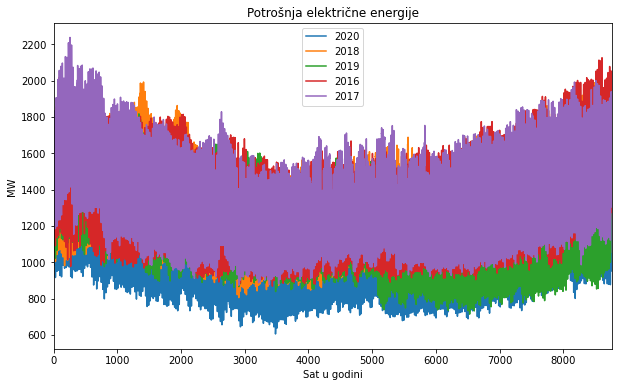

In [225]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(np.arange(len(file3_2020)),file3_2020["Konzum, MWh"], label="2020")
ax.plot(np.arange(len(file3_2018)),file3_2018["Konzum, MWh"], label="2018")
ax.plot(np.arange(len(file3_2019)),file3_2019["Konzum, MWh"], label="2019")

ax.plot(np.arange(len(BA_file2[BA_file2["Godina"]==2016])),BA_file2[BA_file2["Godina"]==2016]["Value"], label="2016")
ax.plot(np.arange(len(BA_file2[BA_file2["Godina"]==2017])),BA_file2[BA_file2["Godina"]==2017]["Value"], label="2017")
ax.legend()
ax.set_title("Potrošnja električne energije")
ax.set_xlabel("Sat u godini")
ax.set_ylabel("MW")
plt.xlim(0,8760)

In [226]:
sorted_2020=file3_2020.sort_values(by="Konzum, MWh",ascending=False)
sorted_2019=file3_2019.sort_values(by="Konzum, MWh",ascending=False)
sorted_2018=file3_2018.sort_values(by="Konzum, MWh",ascending=False)

sorted_2016=BA_file2[BA_file2["Godina"]==2016].sort_values(by="Value",ascending=False)
sorted_2017=BA_file2[BA_file2["Godina"]==2017].sort_values(by="Value",ascending=False)

Sa krive opterećenja (Slika ispod) se može vidjeti da je 25% vremena (2000 sati) u 2020. potrošnja viša od cca.1400 MW, s tim da je maksimalna zabilježena 2237 MW (2017. godina). Za prethodne godine je to obično oko 1600 MW.

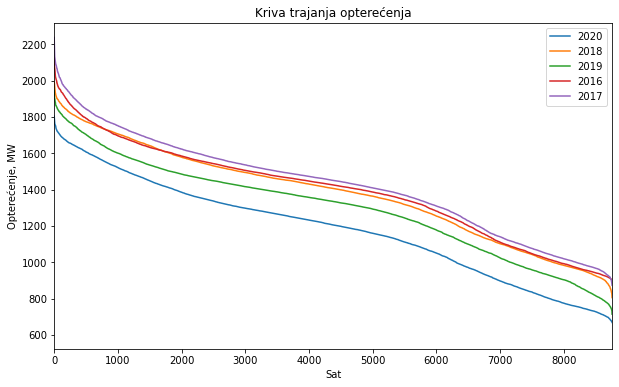

In [227]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(np.arange(len(file3_2020)),sorted_2020["Konzum, MWh"], label="2020")
ax.plot(np.arange(len(file3_2018)),sorted_2018["Konzum, MWh"], label="2018")
ax.plot(np.arange(len(file3_2019)),sorted_2019["Konzum, MWh"], label="2019")
ax.plot(np.arange(len(sorted_2016)),sorted_2016["Value"], label="2016")
ax.plot(np.arange(len(sorted_2017)),sorted_2017["Value"], label="2017")
ax.set_xlim(0,8761)
ax.set_ylabel("Opterećenje, MW")
ax.set_xlabel("Sat")
ax.set_title("Kriva trajanja opterećenja")
ax.legend()
# kriva trajanja će se naknadno iskomentarisati


In [228]:
file3_2020.head(2)

,Datum,"Konzum, kWh","Gubici, MWh","Gubici, MWh.1","Gubici + Konzum, kWh",Godina,Sat,Mjesec,Dan_u_godini,Date,Dan_u_sedmici,Dan_u_mjesecu,"Gubici + Konzum, MWh","Konzum, MWh"
0,01.01.2020 00-01,1208647,37.379,NaN,1246026,2020,0,1,1,2020-01-01,2,1,1246.026,1208.647
1,01.01.2020 01-02,1144023,39.612,NaN,1183635,2020,1,1,1,2020-01-01,2,1,1183.635,1144.023


(1.0, 12.0)

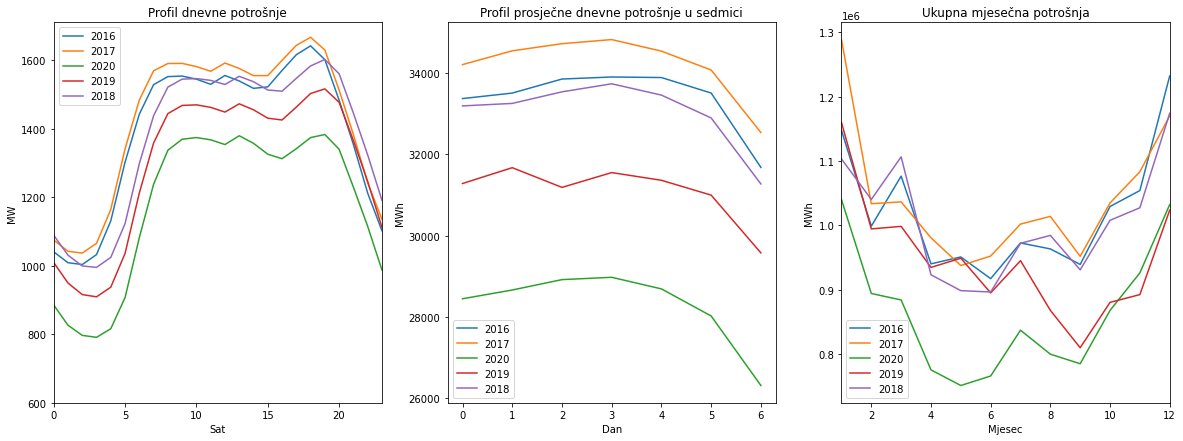

In [229]:
fig,ax = plt.subplots(ncols=3,figsize=(20,7))
# grupisanje po srednjoj vrijednosti po satu u toku godine
BA_file2[BA_file2["Godina"]==2016].groupby("Sat")["Value"].mean().plot(label="2016",ax=ax[0])
BA_file2[BA_file2["Godina"]==2017].groupby("Sat")["Value"].mean().plot(label="2017",ax=ax[0])
file3_2020.groupby("Sat").mean()["Konzum, MWh"].plot(label="2020",ax=ax[0])
file3_2019.groupby("Sat").mean()["Konzum, MWh"].plot(label="2019",ax=ax[0])
file3_2018.groupby("Sat").mean()["Konzum, MWh"].plot(label="2018",ax=ax[0])
ax[0].legend()
ax[0].set_title("Profil dnevne potrošnje")
ax[0].set_xlabel("Sat")
ax[0].set_ylabel("MW")
ax[0].set_xlim(0,23)
ax[0].set_ylim(600)

# sumiranje potrošnje po danima u toku sedmice
f_2016=BA_file2[BA_file2["Godina"]==2016].groupby(["Dan_u_sedmici","Dan_u_godini"])["Value"].sum()
f_2017=BA_file2[BA_file2["Godina"]==2017].groupby(["Dan_u_sedmici","Dan_u_godini"])["Value"].sum()
f_2020=file3_2020.groupby(["Dan_u_sedmici","Dan_u_godini"]).sum()["Konzum, MWh"]
f_2019=file3_2019.groupby(["Dan_u_sedmici","Dan_u_godini"]).sum()["Konzum, MWh"]
f_2018=file3_2018.groupby(["Dan_u_sedmici","Dan_u_godini"]).sum()["Konzum, MWh"]

#prosječna potrošnja po danu u sedmici
f_2016.groupby("Dan_u_sedmici").mean().plot(label="2016",ax=ax[1])
f_2017.groupby("Dan_u_sedmici").mean().plot(label="2017",ax=ax[1])
f_2020.groupby("Dan_u_sedmici").mean().plot(label="2020",ax=ax[1])
f_2019.groupby("Dan_u_sedmici").mean().plot(label="2019",ax=ax[1])
f_2018.groupby("Dan_u_sedmici").mean().plot(label="2018",ax=ax[1])


ax[1].legend()
ax[1].set_title("Profil prosječne dnevne potrošnje u sedmici")
ax[1].set_xlabel("Dan")
ax[1].set_ylabel("MWh")

#Monday=0, Sunday=6.

#ukupna potrošnja po mjesecima u toku godine
grouped_month16=BA_file2[BA_file2["Godina"]==2016].groupby(["Mjesec"])["Value"].sum().plot(label="2016",ax=ax[2])
grouped_month17=BA_file2[BA_file2["Godina"]==2017].groupby(["Mjesec"])["Value"].sum().plot(label="2017",ax=ax[2])

grouped_month20=file3_2020.groupby("Mjesec").sum()["Konzum, MWh"].plot(label="2020",ax=ax[2])
grouped_month19=file3_2019.groupby("Mjesec").sum()["Konzum, MWh"].plot(label="2019",ax=ax[2])
grouped_month18=file3_2018.groupby("Mjesec").sum()["Konzum, MWh"].plot(label="2018",ax=ax[2])


ax[2].legend()
ax[2].set_title("Ukupna mjesečna potrošnja")
ax[2].set_xlabel("Mjesec")
ax[2].set_ylabel("MWh")
ax[2].set_xlim(1,12)



Za svaku godinu je generisan profil dnevne potrošnje po satima, gdje se očekivano može primijetiti da se vršna potrošnja dešava u poslijepodnevnim satima, s tim da je veći dio potrošnje u periodu od (5-20)h, te sredinom sedmice. Potrošnja električne energije bilježi pad vikendom. 

### Usrednjeni profili potražnje

In [230]:
columns1=["Sat","Dan_u_sedmici","Mjesec","Godina","Dan_u_godini","Value"]
columns2=["Sat","Dan_u_sedmici","Mjesec","Godina","Dan_u_godini",'Konzum, MWh']
     
dict1={"Value":'Konzum, MWh'}
BA_file3=BA_file2.rename(columns=dict1)
BA_ALL=pd.concat([BA_file3[columns2],file3_2018[columns2],file3_2019[columns2],file3_2020[columns2]])

In [231]:
BA_ALL=BA_ALL[BA_ALL["Godina"] != 2015] # samo jedna vrijednost postoji 
#za 2015 pa je potrebno izbaciti


Text(-2.700000000000003, 0.5, 'MW')

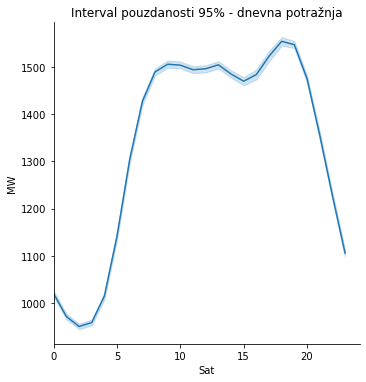

In [232]:
sns.relplot(
    data=BA_ALL, x='Sat', y='Konzum, MWh',kind="line")
plt.title("Interval pouzdanosti 95% - dnevna potražnja")
plt.xlim(0)
plt.xlabel("Sat")
plt.ylabel("MW")

## DIO B

### Preuzimanje podataka sa web stranice

Na web stranici NOS BiH postoje dnevne tabele sa satnim podacima, koje bi se trebale pojedinačno kopirati u Excel fajl. Za ovo je kreiran kod koji kombinira HTML kod web stranice kako bi se automatizovao proces izbora dana i kopiranja podataka. Dobivene fajlove je ipak potrebno na kraju modifikovati radi datuma s obzirom da poteškoće stvaraju dani za koje tabele nisu dostupne. Ovaj dio se može odraditi ručno u kratkom periodu nakon što se dobiju željeni podaci.

In [381]:
#%pip install requests
#%pip install bs4
#%%pip install lxml
import datetime as dt

import requests
from bs4 import BeautifulSoup

import re

import time
from bs4 import BeautifulSoup

# Import webdriver to initialise a browser
from selenium import webdriver
from selenium.webdriver import ActionChains

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By

In [38]:
date_list1=pd.date_range("2020-12-31","2022-01-01", freq="1D").strftime("%d.%m.%Y.")

In [ ]:
#ne pokretati - stavit će se u auxilliary
# website
url = "https://www.nosbih.ba/bs/ees/graf-potrosnje/"

# Initialize webdriver 
driver = webdriver.Chrome(executable_path=r'C:\\Users\\Ehlimana\\Desktop\\chromedriver.exe')

# Launch Chrome and pass the url
driver.get(url)
dfs=[None]*len(date_list1)
#date selection
for k, value in enumerate(date_list1):
    
    
    # Made a list of all elements that have "day" on the id.
    list_days = driver.find_elements_by_class_name("day")
    # Now I get the len of that list
    count = len(list_days)
    # Loop over each element of the list count
    for i in range(count):
        # And I get the link to the element 
        python_botton = driver.find_elements_by_class_name("day")[i]
         # I will click on the day button.
        if python_botton.get_attribute('class') == "day":
            ActionChains(driver).click(python_botton).perform()
            # Wait for the page to update 
            time.sleep(10)
            # Now parse the page 
            soup = BeautifulSoup(driver.page_source, 'lxml')

   
    
    next3 = driver.find_element_by_name("date").clear()
    next3 = driver.find_element_by_name("date").send_keys(value)#send date info to datebox
    #next3.submit()
    next1 = driver.find_element_by_id("selectDateRegionButton") .click()
   
    ActionChains(driver).click(next1).perform() 
    
    next2 = driver.find_element_by_id("nav-production-table-tab").click()                                      
    ActionChains(driver).click(next2).perform()
    
    
    driver.implicitly_wait(8)
    table1 = driver.find_element_by_id('productionTable')
    
    print(date_list1[k])
    	#table1
    dfs[k]=pd.read_html(driver.find_element_by_xpath('//*[@id="productionTable"]').get_attribute('outerHTML'))[0]
    dfs[k]=dfs[k].assign(Date=create_datarange_2021[k])

In [ ]:
df_tot=pd.concat(dfs,axis=0)
df_tot.to_excel("NOS_BiH_2021.xlsx")

### Otvaranje fajlova

In [233]:
file_NOS_2021=pd.read_excel(r"FILES\ELEKT\NOS_BiH_2021.xlsx",header=0,sheet_name=0)#taabela modifikovana u excelu sa  date index
file_NOS_2020=pd.read_excel(r"FILES\ELEKT\NOS_BiH_2020.xlsx",header=0,sheet_name=0)#taabela modifikovana u excelu sa  date index

In [234]:
file_NOS_2020.head(2)

,Unnamed: 0,Vrijeme,Planirana proizvodnja,Ostvarena proizvodnja,Planirana potrošnja,Ostvarena potrošnja,Date
0,0,01:00,1899.0,1905.32,1211.0,1498.34,11.01.2020.
1,1,02:00,1722.0,1749.79,1090.0,1410.16,11.01.2020.


In [235]:
file_NOS_2021=file_NOS_2021.assign(Mjesec=pd.to_datetime(file_NOS_2021["Date"]).dt.month)
file_NOS_2020=file_NOS_2020.assign(Mjesec=pd.to_datetime(file_NOS_2020["Date"]).dt.month)

In [236]:
file_NOS_2020.head(2)

,Unnamed: 0,Vrijeme,Planirana proizvodnja,Ostvarena proizvodnja,Planirana potrošnja,Ostvarena potrošnja,Date,Mjesec
0,0,01:00,1899.0,1905.32,1211.0,1498.34,11.01.2020.,11
1,1,02:00,1722.0,1749.79,1090.0,1410.16,11.01.2020.,11


Oba fajla imaju praznine u podacima, te se to može vidjeti u narednim ćelijama, s tim da je najmanji broj praznina među planiranim vrijednostima.

In [237]:
print("Ne postoje ostvarene proizvodnje za 2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Ostvarena proizvodnja"])]["Date"].unique()

Ne postoje ostvarene proizvodnje za 2020:


array(['13.01.2020.', '14.01.2020.', '29.03.2020.', '13.04.2020.',
       '22.04.2020.', '25.04.2020.', '27.04.2020.', '12.05.2020.',
       '13.05.2020.', '18.05.2020.', '21.05.2020.', '22.05.2020.',
       '25.05.2020.', '26.05.2020.', '27.05.2020.', '31.05.2020.',
       '01.06.2020.', '02.06.2020.', '03.06.2020.', '05.06.2020.',
       '06.06.2020.', '08.06.2020.', '15.06.2020.', '16.06.2020.',
       '17.06.2020.', '22.06.2020.', '30.06.2020.', '06.07.2020.',
       '08.07.2020.', '09.07.2020.', '10.07.2020.', '11.07.2020.',
       '13.07.2020.', '19.07.2020.', '20.07.2020.', '21.07.2020.',
       '22.07.2020.', '23.07.2020.', '24.07.2020.', '27.07.2020.',
       '03.08.2020.', '04.08.2020.', '05.08.2020.', '06.08.2020.',
       '07.08.2020.', '09.08.2020.', '10.08.2020.', '11.08.2020.',
       '25.08.2020.', '26.08.2020.', '20.09.2020.', '23.09.2020.',
       '24.09.2020.', '25.09.2020.', '26.09.2020.', '06.10.2020.',
       '07.10.2020.', '25.10.2020.', '02.11.2020.', '07.11.202

In [238]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Ostvarena potrošnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:


array(['13.01.2020.', '14.01.2020.', '29.03.2020.', '13.04.2020.',
       '14.04.2020.', '15.04.2020.', '16.04.2020.', '17.04.2020.',
       '27.04.2020.', '28.04.2020.', '02.05.2020.', '07.05.2020.',
       '13.05.2020.', '15.05.2020.', '18.05.2020.', '21.05.2020.',
       '22.05.2020.', '25.05.2020.', '26.05.2020.', '27.05.2020.',
       '31.05.2020.', '01.06.2020.', '02.06.2020.', '03.06.2020.',
       '05.06.2020.', '06.06.2020.', '08.06.2020.', '15.06.2020.',
       '16.06.2020.', '17.06.2020.', '22.06.2020.', '30.06.2020.',
       '06.07.2020.', '08.07.2020.', '09.07.2020.', '10.07.2020.',
       '13.07.2020.', '19.07.2020.', '20.07.2020.', '21.07.2020.',
       '22.07.2020.', '24.07.2020.', '27.07.2020.', '03.08.2020.',
       '04.08.2020.', '05.08.2020.', '06.08.2020.', '09.08.2020.',
       '10.08.2020.', '11.08.2020.', '16.08.2020.', '25.08.2020.',
       '26.08.2020.', '15.09.2020.', '20.09.2020.', '23.09.2020.',
       '24.09.2020.', '25.09.2020.', '26.09.2020.', '06.10.202

In [239]:
print("Ne postoje ostvarene potrošnje za 2021:")
indices= np.where(pd.isnull(file_NOS_2021))
file_NOS_2021[pd.isnull(file_NOS_2021["Ostvarena proizvodnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za 2021:


array(['02.01.2021', '12.02.2021', '15.02.2021', '24.02.2021',
       '11.03.2021', '17.03.2021', '19.03.2021', '24.03.2021',
       '28.03.2021', '29.03.2021', '30.03.2021', '06.04.2021',
       '08.04.2021', '09.04.2021', '13.04.2021', '15.04.2021',
       '19.04.2021', '27.04.2021', '04.05.2021', '05.05.2021',
       '07.05.2021', '11.05.2021', '13.06.2021', '14.06.2021',
       '05.07.2021', '07.07.2021', '09.07.2021', '13.07.2021',
       '16.07.2021', '26.07.2021', '28.07.2021', '29.07.2021',
       '30.07.2021', '31.07.2021', '26.08.2021', '21.10.2021',
       '24.10.2021', '25.10.2021', '26.10.2021', '05.11.2021',
       '21.12.2021', '22.12.2021'], dtype=object)

In [240]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Planirana proizvodnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:


array(['25.03.2020.', '26.03.2020.', '25.10.2020.'], dtype=object)

In [241]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Planirana potrošnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima2020:


array(['25.03.2020.', '26.03.2020.', '29.11.2020.', '30.11.2020.',
       '01.12.2020.'], dtype=object)

In [242]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:")
indices= np.where(pd.isnull(file_NOS_2021))
file_NOS_2021[pd.isnull(file_NOS_2021["Planirana proizvodnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:


array(['15.07.2021', '16.07.2021', '30.07.2021', '31.07.2021',
       '31.10.2021', '21.11.2021'], dtype=object)

In [243]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:")
indices= np.where(pd.isnull(file_NOS_2021))
file_NOS_2021[pd.isnull(file_NOS_2021["Planirana potrošnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:


array([], dtype=object)

In [244]:
file_NOS_2020.rename(columns = {"Planirana proizvodnja":"Planirana proizvodnja-2020.",
                                "Ostvarena proizvodnja":"Ostvarena proizvodnja-2020.",
                                "Planirana potrošnja":"Planirana potrošnja-2020.",
                                "Ostvarena potrošnja":"Ostvarena potrošnja-2020."}, inplace = True)

In [245]:
file_NOS_2021.rename(columns = {"Planirana proizvodnja":"Planirana proizvodnja-2021.",
                                "Ostvarena proizvodnja":"Ostvarena proizvodnja-2021.",
                                "Planirana potrošnja":"Planirana potrošnja-2021.",
                                "Ostvarena potrošnja":"Ostvarena potrošnja-2021."}, inplace = True)

Može se primijetiti da je ostvarena proizvodnja nekada značajno veća od planirane proizvodnje.

Text(0, 0.5, 'Proizvodnja, MW')

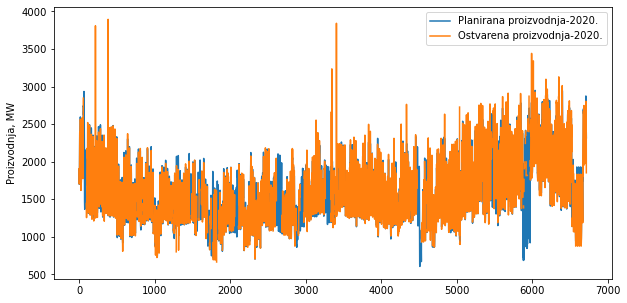

In [246]:
file_NOS_2020[["Planirana proizvodnja-2020.",'Ostvarena proizvodnja-2020.']].astype(float).plot(figsize=(10,5))
plt.legend()
plt.ylabel("Proizvodnja, MW")

In [247]:
file_NOS_2020[file_NOS_2020["Ostvarena proizvodnja-2020."]>3000]

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2020.,Ostvarena proizvodnja-2020.,Planirana potrošnja-2020.,Ostvarena potrošnja-2020.,Date,Mjesec
217,2,03:00,1281.0,3808.50,820.0,3027.57,30.03.2020.,3
385,2,03:00,1297.0,3893.97,1003.0,3176.49,06.04.2020.,6
3348,13,14:00,1714.0,3234.76,1397.0,2578.02,07.08.2020.,7
3409,2,03:00,1301.0,3841.68,753.0,2347.23,10.08.2020.,10
5994,18,19:00,2698.0,3440.91,1740.0,2419.59,01.12.2020.,1
6017,17,18:00,2913.0,3340.83,1847.0,2090.77,02.12.2020.,2
6184,16,17:00,2826.0,3097.12,1646.0,1780.24,09.12.2020.,9
6354,18,19:00,2698.0,3128.20,1746.0,2232.23,16.12.2020.,12
6400,16,17:00,2944.0,3012.00,1824.0,1677.92,18.12.2020.,12


Text(0, 0.5, 'Proizvodnja, MW')

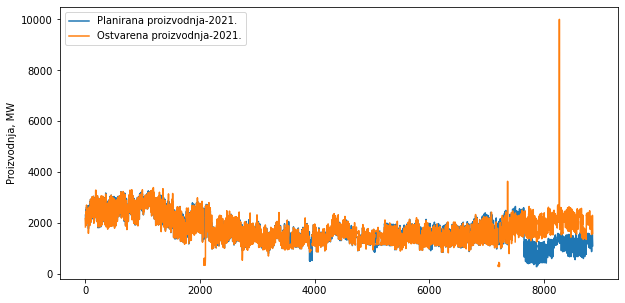

In [248]:
file_NOS_2021[["Planirana proizvodnja-2021.","Ostvarena proizvodnja-2021."]].astype(float).plot(figsize=(10,5))
plt.legend()
plt.ylabel("Proizvodnja, MW")

In [249]:
file_NOS_2021[file_NOS_2021["Ostvarena proizvodnja-2021."]>8000] #anomalija ili ekstrem

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2021.,Ostvarena proizvodnja-2021.,Planirana potrošnja-2021.,Ostvarena potrošnja-2021.,Date,Mjesec
8274,17,18:00,1525.0,9999.99,1747,9999.99,07.12.2021,7


Na mjesečnoj bazi, planirana proivodnja je sumarno uvijek veća od ostvarene, dok je ostvarena potrošnja u 2020. godini u zimskim mjesecima sumarno bila veća od planirane (iako je generalno tada zabilježen pad potrošnje usljed isključenja nekih velikih potrošača). Ovo nije slučaj u 2021. godini, ali se u 2021. godini u zimskim mjesecima bilježi značajno veća ostvarena proizvodnja od planirane, što može biti posljedica dobrih hidroloških prilika, te povećane proizvodnje iz HE.

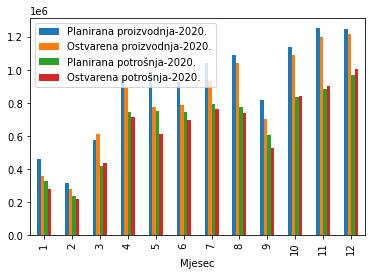

In [250]:
file_NOS_2020.groupby("Mjesec")[["Planirana proizvodnja-2020.",'Ostvarena proizvodnja-2020.',"Planirana potrošnja-2020.", "Ostvarena potrošnja-2020."]].sum().plot(kind="bar")
plt.show()

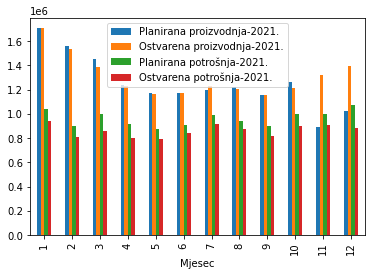

In [251]:
file_NOS_2021.groupby("Mjesec")[["Planirana proizvodnja-2021.",'Ostvarena proizvodnja-2021.',"Planirana potrošnja-2021.", "Ostvarena potrošnja-2021."]].sum().plot(kind="bar")
plt.show()

<AxesSubplot:>

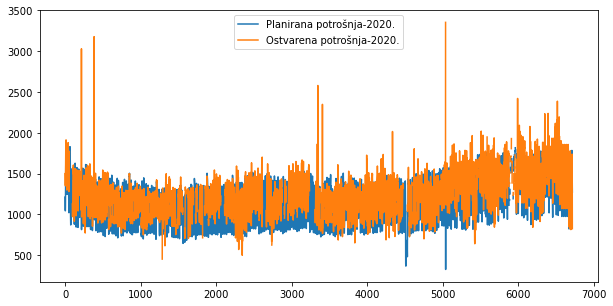

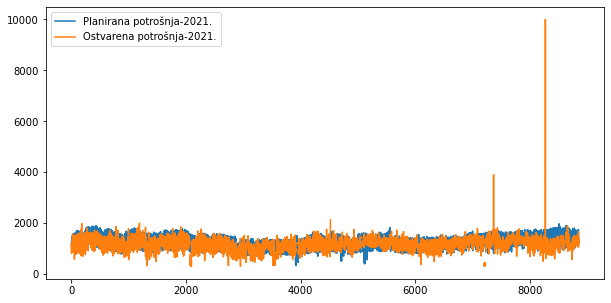

In [252]:
file_NOS_2020[["Planirana potrošnja-2020.", "Ostvarena potrošnja-2020."]].astype(float).plot(figsize=(10,5))
file_NOS_2021[["Planirana potrošnja-2021.", "Ostvarena potrošnja-2021."]].plot(figsize=(10,5))

In [253]:
file_NOS_2021[file_NOS_2021["Ostvarena potrošnja-2021."]>2000]

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2021.,Ostvarena proizvodnja-2021.,Planirana potrošnja-2021.,Ostvarena potrošnja-2021.,Date,Mjesec
1187,10,11:00,3192.0,3291.37,1660,2004.17,19.02.2021,2
4521,9,10:00,2008.0,2030.81,1376,2131.87,07.07.2021,7
7369,1,02:00,1174.0,3643.92,1165,3902.40,31.10.2021,10
7370,2,02:00,NaN,3643.92,815,3902.40,31.10.2021,10
8274,17,18:00,1525.0,9999.99,1747,9999.99,07.12.2021,7


In [254]:
file_NOS_2020[file_NOS_2020["Ostvarena potrošnja-2020."]>2000]

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2020.,Ostvarena proizvodnja-2020.,Planirana potrošnja-2020.,Ostvarena potrošnja-2020.,Date,Mjesec
217,2,03:00,1281.0,3808.50,820.0,3027.57,30.03.2020.,3
385,2,03:00,1297.0,3893.97,1003.0,3176.49,06.04.2020.,6
3348,13,14:00,1714.0,3234.76,1397.0,2578.02,07.08.2020.,7
3409,2,03:00,1301.0,3841.68,753.0,2347.23,10.08.2020.,10
4337,18,19:00,2094.0,2762.50,1254.0,2014.36,17.09.2020.,9
5040,1,02:00,972.0,2726.25,1023.0,3351.51,25.10.2020.,10
5512,16,17:00,2447.0,2768.13,1677.0,2019.25,13.11.2020.,11
5994,18,19:00,2698.0,3440.91,1740.0,2419.59,01.12.2020.,1
6017,17,18:00,2913.0,3340.83,1847.0,2090.77,02.12.2020.,2
6023,23,00:00,2068.0,2277.52,1540.0,2018.68,03.12.2020.,3


In [255]:
print("Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2020.:")
print(file_NOS_2020[file_NOS_2020["Ostvarena proizvodnja-2020."]>file_NOS_2020["Planirana proizvodnja-2020."]][["Mjesec","Date"]].groupby("Mjesec").count())

print("Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2021.:")
print(file_NOS_2021[file_NOS_2021["Ostvarena proizvodnja-2021."]>file_NOS_2021["Planirana proizvodnja-2021."]][["Mjesec","Date"]].groupby("Mjesec").count())

Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2020.:
        Date
Mjesec      
1         98
2         66
3        108
4        248
5        190
6        222
7        326
8        246
9        216
10       269
11       320
12       298
Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2021.:
        Date
Mjesec      
1        202
2        244
3        253
4        314
5        296
6        337
7        444
8        258
9        314
10       256
11       560
12       573


In [256]:
print("Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2020.:")
print(file_NOS_2020[file_NOS_2020["Ostvarena potrošnja-2020."]>file_NOS_2020["Planirana potrošnja-2020."]][["Mjesec","Date"]].groupby("Mjesec").count())


print("Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2021.:")
print(file_NOS_2021[file_NOS_2021["Ostvarena potrošnja-2021."]>file_NOS_2021["Planirana potrošnja-2021."]][["Mjesec","Date"]].groupby("Mjesec").count())

Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2020.:
        Date
Mjesec      
1        126
2        104
3        173
4        361
5        352
6        386
7        386
8        315
9        278
10       381
11       406
12       493
Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2021.:
        Date
Mjesec      
1        130
2        185
3        177
4        130
5        208
6        281
7        310
8        271
9        155
10       224
11       220
12       108


# Prekogranični tokovi

In [257]:
cross_CRO_2019=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_CRO_2019.csv",header=0,sep=",")
cross_CRO_2020=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_CRO_2020.csv",header=0,sep=",")
cross_CRO_2021=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_CRO_2021.csv",header=0,sep=",")

In [258]:
cross_CRO_2019.columns

Index(['Time (CET)', 'BZN|HR > BZN|BA [MW]', 'BZN|BA > BZN|HR [MW]'], dtype='object')

In [259]:
def arange_csv(csv,columns1):
    csv=csv[csv.columns[0]].str.split(",",expand=True)
    csv=csv.applymap(lambda x: x.replace('"', ''))
    csv.columns=columns1
    return csv

In [260]:
columns_cro=["Time (CET)","BZN|HR > BZN|BA [MW]","BZN|BA > BZN|HR [MW]"]
#cross_CRO_2019=arange_csv(cross_CRO_2019,columns_cro)
#cross_CRO_2020=arange_csv(cross_CRO_2020,columns_cro)
#cross_CRO_2021=arange_csv(cross_CRO_2021,columns_cro)

In [261]:
cross_CRO_2019["BZN|HR > BZN|BA [MW]"]=pd.to_numeric(cross_CRO_2019["BZN|HR > BZN|BA [MW]"])
cross_CRO_2019["BZN|BA > BZN|HR [MW]"]=pd.to_numeric(cross_CRO_2019["BZN|BA > BZN|HR [MW]"])

In [262]:
cross_CRO_2019=cross_CRO_2019.assign(Timestamp=pd.date_range("2019-01-01 00:00:00","2020-01-01", freq="1H"))
cross_CRO_2020=cross_CRO_2020.assign(Timestamp=pd.date_range("2020-01-01 00:00:00","2021-01-01", freq="1H"))
cross_CRO_2021=cross_CRO_2021.assign(Timestamp=pd.date_range("2021-01-01 00:00:00","2022-01-01", freq="1H"))

In [263]:
print("2019\n")
print(cross_CRO_2019[cross_CRO_2019.columns[1:3]].describe())
print("2020\n")
print(cross_CRO_2020[cross_CRO_2019.columns[1:3]].describe())
print("2021\n")
print(cross_CRO_2021[cross_CRO_2019.columns[1:3]].describe())

2019

       BZN|HR > BZN|BA [MW]  BZN|BA > BZN|HR [MW]
count           8760.000000           8760.000000
mean              76.848973            186.042694
std              142.738367            243.617016
min                0.000000              0.000000
25%                0.000000              0.000000
50%                0.000000             84.000000
75%              102.250000            301.250000
max             1065.000000           1588.000000
2020

       BZN|HR > BZN|BA [MW]  BZN|BA > BZN|HR [MW]
count           8784.000000           8784.000000
mean             181.001708             99.674522
std              224.023232            185.129705
min                0.000000              0.000000
25%                0.000000              0.000000
50%               91.000000              0.000000
75%              306.000000            132.000000
max             1165.000000           1323.000000
2021

       BZN|HR > BZN|BA [MW]  BZN|BA > BZN|HR [MW]
count           8760.000000     

In [264]:
cross_CRO_2019["Month"]=cross_CRO_2019["Timestamp"].dt.month
cross_CRO_2020["Month"]=cross_CRO_2020["Timestamp"].dt.month
cross_CRO_2021["Month"]=cross_CRO_2021["Timestamp"].dt.month

Text(0, 0.5, 'MW')

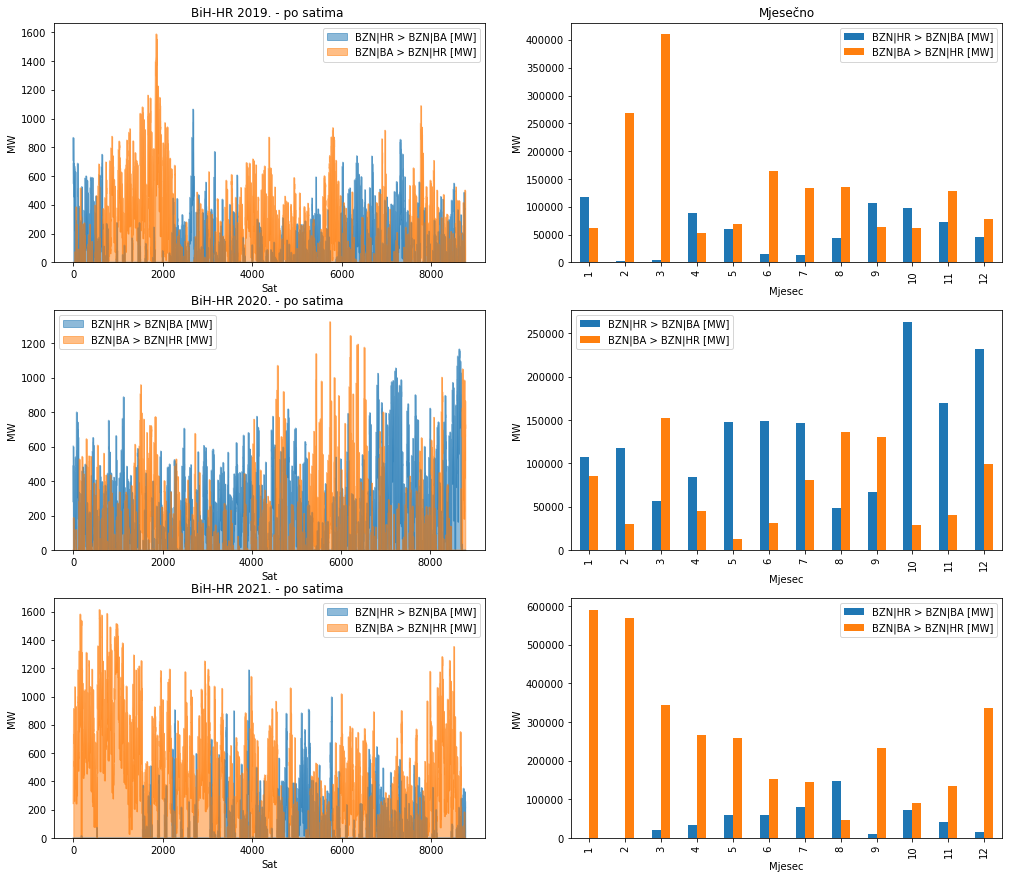

In [265]:
col_cro=cross_CRO_2019.columns[1:3]
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,15))
cross_CRO_2019[col_cro].plot(kind="area",stacked=False,ax=ax[0,0])
cross_CRO_2019.groupby("Month")[col_cro].sum().plot(kind="bar",ax=ax[0,1])
ax[0,0].set_title("BiH-HR 2019. - po satima ")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

cross_CRO_2020[col_cro].plot(kind="area",stacked=False,ax=ax[1,0])
cross_CRO_2020.groupby("Month")[col_cro].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("BiH-HR 2020. - po satima ")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

cross_CRO_2021[col_cro].plot(kind="area",stacked=False,ax=ax[2,0])
cross_CRO_2021.groupby("Month")[col_cro].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("BiH-HR 2021. - po satima ")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")

In [266]:
cross_MNE_2019=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_MNE_2019.csv",header=0,sep=",")
cross_MNE_2020=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_MNE_2020.csv",header=0,sep=",")
cross_MNE_2021=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_MNE_2021.csv",header=0,sep=",")

In [267]:
cross_MNE_2021.columns

Index(['Time (CET)', 'BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]'], dtype='object')

In [268]:
columns_MNE=["Time (CET)","BZN|ME > BZN|BA [MW]","BZN|BA > BZN|ME [MW]"]

In [269]:
cross_MNE_2019=cross_MNE_2019.assign(Timestamp=pd.date_range("2019-01-01 00:00:00","2020-01-01", freq="1H"))
cross_MNE_2020=cross_MNE_2020.assign(Timestamp=pd.date_range("2020-01-01 00:00:00","2021-01-01", freq="1H"))
cross_MNE_2021=cross_MNE_2021.assign(Timestamp=pd.date_range("2021-01-01 00:00:00","2022-01-01", freq="1H"))

In [270]:
print("2019\n")
print(cross_MNE_2019[cross_MNE_2019.columns[1:3]].describe())
print("2020\n")
print(cross_MNE_2020[cross_MNE_2020.columns[1:3]].describe())
print("2021\n")
print(cross_MNE_2021[cross_MNE_2021.columns[1:3]].describe())

2019

       BZN|ME > BZN|BA [MW]  BZN|BA > BZN|ME [MW]
count           8759.000000           8759.000000
mean              37.156867            305.663889
std               38.578271            157.234909
min                0.000000              0.000000
25%                5.000000            193.000000
50%               25.000000            303.000000
75%               59.000000            407.000000
max              267.000000           1138.000000
2020

       BZN|ME > BZN|BA [MW]  BZN|BA > BZN|ME [MW]
count           8768.000000           8768.000000
mean              42.065807            434.417427
std               54.400235            203.690618
min                0.000000              0.000000
25%                0.000000            291.000000
50%               24.000000            427.000000
75%               69.000000            569.000000
max              566.000000           1553.000000
2021

       BZN|ME > BZN|BA [MW]  BZN|BA > BZN|ME [MW]
count           8760.000000     

In [271]:
cross_MNE_2019["Month"]=cross_MNE_2019["Timestamp"].dt.month
cross_MNE_2020["Month"]=cross_MNE_2020["Timestamp"].dt.month
cross_MNE_2021["Month"]=cross_MNE_2021["Timestamp"].dt.month

Text(0, 0.5, 'MW')

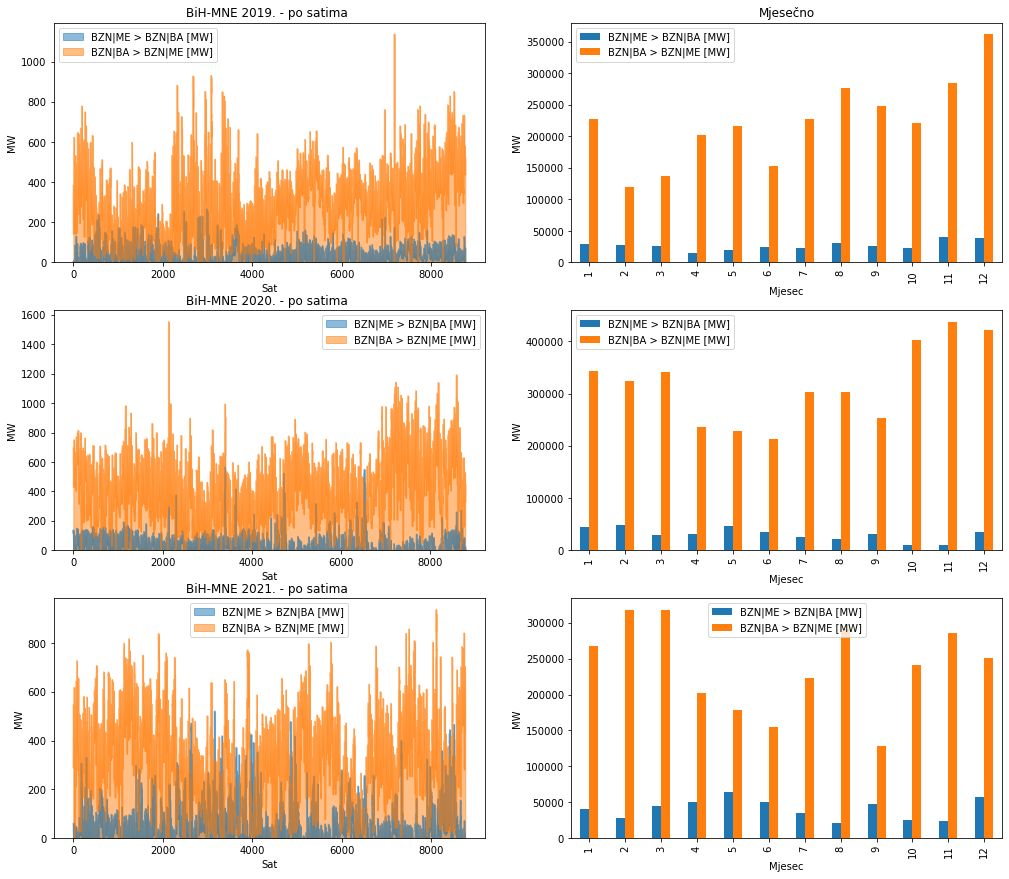

In [272]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,15))
cross_mne=cross_MNE_2019.columns[1:3]
cross_MNE_2019[cross_mne].plot(kind="area",stacked=False,ax=ax[0,0])
cross_MNE_2019.groupby("Month")[cross_mne].sum().plot(kind="bar",ax=ax[0,1])

ax[0,0].set_title("BiH-MNE 2019. - po satima ")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

cross_MNE_2020[cross_mne].plot(kind="area",stacked=False,ax=ax[1,0])
cross_MNE_2020.groupby("Month")[cross_mne].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("BiH-MNE 2020. - po satima ")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

cross_MNE_2021[cross_mne].plot(kind="area",stacked=False,ax=ax[2,0])
cross_MNE_2021.groupby("Month")[cross_mne].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("BiH-MNE 2021. - po satima ")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")

In [273]:
cross_SRB_2019=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_SERB_2019.csv",header=0,sep=",")
cross_SRB_2020=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_SERB_2020.csv",header=0,sep=",")
cross_SRB_2021=pd.read_csv(r"FILES\ELEKT\Cross-Border Physical Flow_BIH_SERB_2021.csv",header=0,sep=",")

In [274]:
cross_SRB_2021.columns

Index(['Time (CET)', 'BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]'], dtype='object')

In [275]:
columns_srb=["Time (CET)",'BZN|RS > BZN|BA [MW]','BZN|BA > BZN|RS [MW]']

In [276]:
cross_SRB_2019=cross_SRB_2019.assign(Timestamp=pd.date_range("2019-01-01 00:00:00","2020-01-01", freq="1H"))
cross_SRB_2020=cross_SRB_2020.assign(Timestamp=pd.date_range("2020-01-01 00:00:00","2021-01-01", freq="1H"))
cross_SRB_2021=cross_SRB_2021.assign(Timestamp=pd.date_range("2021-01-01 00:00:00","2022-01-01", freq="1H"))

In [277]:
print("2019\n")
print(cross_SRB_2019[cross_SRB_2019.columns[1:3]].describe())
print("2020\n")
print(cross_SRB_2020[cross_SRB_2020.columns[1:3]].describe())
print("2021\n")
print(cross_SRB_2021[cross_SRB_2021.columns[1:3]].describe())

2019

       BZN|RS > BZN|BA [MW]  BZN|BA > BZN|RS [MW]
count           8760.000000           8760.000000
mean              59.298744             90.465297
std              117.272928            112.384044
min                0.000000              0.000000
25%                0.000000              0.000000
50%                0.000000             42.000000
75%               73.000000            156.000000
max              780.000000            631.000000
2020

       BZN|RS > BZN|BA [MW]  BZN|BA > BZN|RS [MW]
count           8784.000000           8784.000000
mean              22.505920            118.893101
std               54.081504            115.018124
min                0.000000              0.000000
25%                0.000000              0.000000
50%                0.000000             93.000000
75%                1.000000            198.250000
max              431.000000            524.000000
2021

       BZN|RS > BZN|BA [MW]  BZN|BA > BZN|RS [MW]
count           8760.000000     

In [278]:
cross_SRB_2019["Month"]=cross_SRB_2019["Timestamp"].dt.month
cross_SRB_2020["Month"]=cross_SRB_2020["Timestamp"].dt.month
cross_SRB_2021["Month"]=cross_SRB_2021["Timestamp"].dt.month

Text(0, 0.5, 'MW')

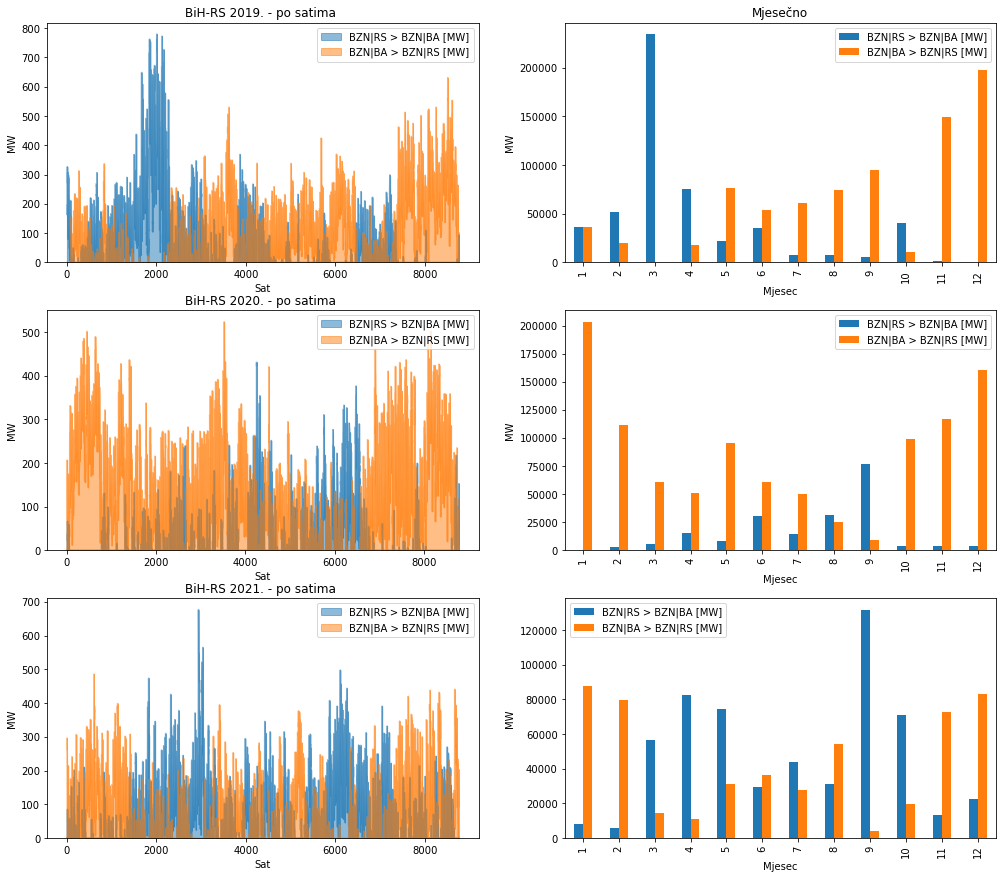

In [279]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,15))
columns_srb=cross_SRB_2019.columns[1:3]
cross_SRB_2019[columns_srb].plot(kind="area",stacked=False,ax=ax[0,0])
cross_SRB_2019.groupby("Month")[columns_srb].sum().plot(kind="bar",ax=ax[0,1])

ax[0,0].set_title("BiH-RS 2019. - po satima ")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

cross_SRB_2020[columns_srb].plot(kind="area",stacked=False,ax=ax[1,0])
cross_SRB_2020.groupby("Month")[columns_srb].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("BiH-RS 2020. - po satima ")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

cross_SRB_2021[columns_srb].plot(kind="area",stacked=False,ax=ax[2,0])
cross_SRB_2021.groupby("Month")[columns_srb].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("BiH-RS 2021. - po satima ")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")

In [280]:
import_total_2019=pd.concat([cross_CRO_2019["Month"],cross_CRO_2019[col_cro[0]],cross_MNE_2019[cross_mne[0]],cross_SRB_2019[columns_srb[0]]],axis=1)
import_total_2020=pd.concat([cross_CRO_2020["Month"],cross_CRO_2020[col_cro[0]],cross_MNE_2020[cross_mne[0]],cross_SRB_2020[columns_srb[0]]],axis=1)
import_total_2021=pd.concat([cross_CRO_2021["Month"],cross_CRO_2021[col_cro[0]],cross_MNE_2021[cross_mne[0]],cross_SRB_2021[columns_srb[0]]],axis=1)

In [281]:
import_total_2019.columns

Index(['Month', 'BZN|HR > BZN|BA [MW]', 'BZN|ME > BZN|BA [MW]',
       'BZN|RS > BZN|BA [MW]'],
      dtype='object')

Text(0, 0.5, 'MW')

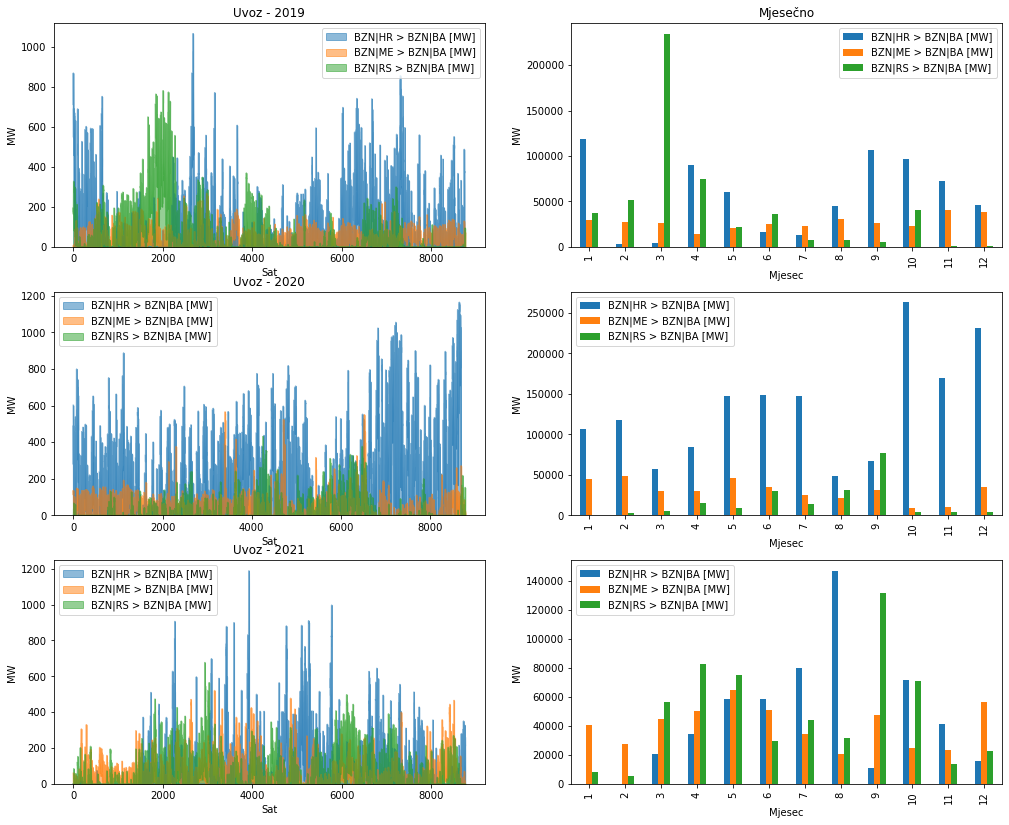

In [282]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,14))
total_col=import_total_2019.columns[1:4]
import_total_2019[total_col].plot(kind="area",stacked=False,ax=ax[0,0])
import_total_2019.groupby("Month")[total_col].sum().plot(kind="bar",ax=ax[0,1])

ax[0,0].set_title("Uvoz - 2019")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

import_total_2020[total_col].plot(kind="area",stacked=False,ax=ax[1,0])
import_total_2020.groupby("Month")[total_col].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("Uvoz - 2020")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

import_total_2021[total_col].plot(kind="area",stacked=False,ax=ax[2,0])
import_total_2021.groupby("Month")[total_col].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("Uvoz - 2021")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")



In [283]:
export_total_2019=pd.concat([cross_CRO_2019["Month"],cross_CRO_2019[col_cro[1]],cross_MNE_2019[cross_mne[1]],cross_SRB_2019[columns_srb[1]]],axis=1)
export_total_2020=pd.concat([cross_CRO_2020["Month"],cross_CRO_2020[col_cro[1]],cross_MNE_2020[cross_mne[1]],cross_SRB_2020[columns_srb[1]]],axis=1)
export_total_2021=pd.concat([cross_CRO_2021["Month"],cross_CRO_2021[col_cro[1]],cross_MNE_2021[cross_mne[1]],cross_SRB_2021[columns_srb[1]]],axis=1)

Text(0, 0.5, 'MW')

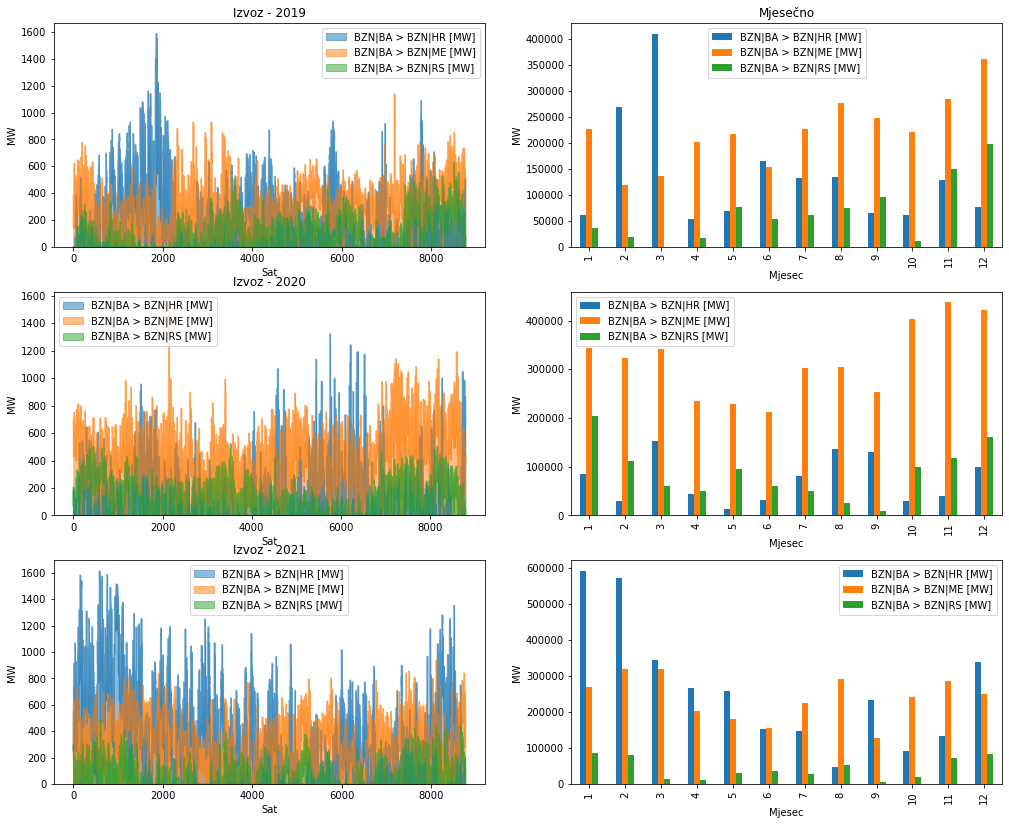

In [284]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,14))
total_col=export_total_2019.columns[1:4]
export_total_2019[total_col].plot(kind="area",stacked=False,ax=ax[0,0])
export_total_2019.groupby("Month")[total_col].sum().plot(kind="bar",ax=ax[0,1])

ax[0,0].set_title("Izvoz - 2019")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

export_total_2020[total_col].plot(kind="area",stacked=False,ax=ax[1,0])
export_total_2020.groupby("Month")[total_col].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("Izvoz - 2020")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

export_total_2021[total_col].plot(kind="area",stacked=False,ax=ax[2,0])
export_total_2021.groupby("Month")[total_col].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("Izvoz - 2021")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")



In [285]:
import_total_2019["Import"]=import_total_2019[import_total_2019.columns[1:4]].sum(axis=1)
import_total_2020["Import"]=import_total_2020[import_total_2020.columns[1:4]].sum(axis=1)
import_total_2021["Import"]=import_total_2021[import_total_2021.columns[1:4]].sum(axis=1)

export_total_2019["Export"]=export_total_2019[export_total_2019.columns[1:4]].sum(axis=1)
export_total_2020["Export"]=export_total_2020[export_total_2020.columns[1:4]].sum(axis=1)
export_total_2021["Export"]=export_total_2021[export_total_2021.columns[1:4]].sum(axis=1)

In [286]:
net_2019=pd.concat([import_total_2019[["Month","Import"]],export_total_2019["Export"]],axis=1)
net_2020=pd.concat([import_total_2020[["Month","Import"]],export_total_2020["Export"]],axis=1)
net_2021=pd.concat([import_total_2021[["Month","Import"]],export_total_2021["Export"]],axis=1)



In [287]:
net_2019=net_2019.assign(Diff=net_2019['Export'].sub(net_2019['Import']))
net_2020=net_2020.assign(Diff=net_2020['Export'].sub(net_2020['Import']))
net_2021=net_2021.assign(Diff=net_2021['Export'].sub(net_2021['Import']))

Text(0, 0.5, 'MW')

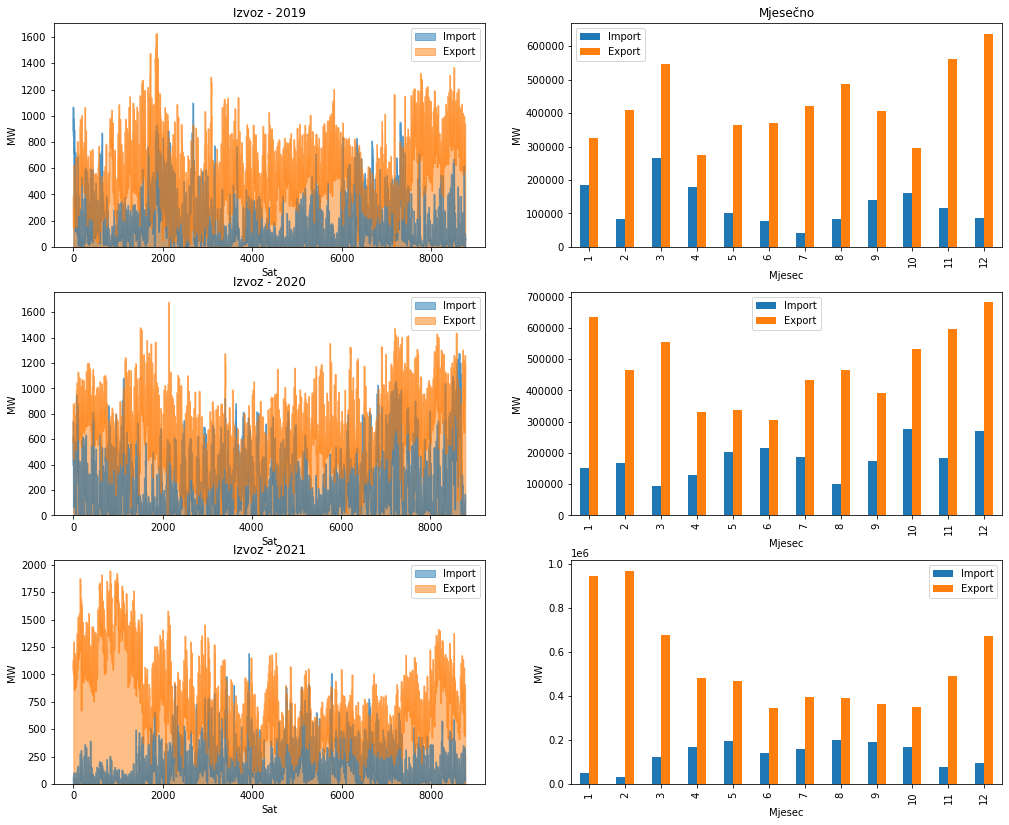

In [288]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,14))
cols_imp_exp=net_2019.columns[1:3]

net_2019[cols_imp_exp].plot(kind="area",stacked=False,ax=ax[0,0])
net_2019.groupby("Month")[cols_imp_exp].sum().plot(kind="bar",ax=ax[0,1])

ax[0,0].set_title("Izvoz - 2019")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

net_2020[cols_imp_exp].plot(kind="area",stacked=False,ax=ax[1,0])
net_2020.groupby("Month")[cols_imp_exp].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("Izvoz - 2020")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

net_2021[cols_imp_exp].plot(kind="area",stacked=False,ax=ax[2,0])
net_2021.groupby("Month")[cols_imp_exp].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("Izvoz - 2021")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")



Text(0, 0.5, 'MW')

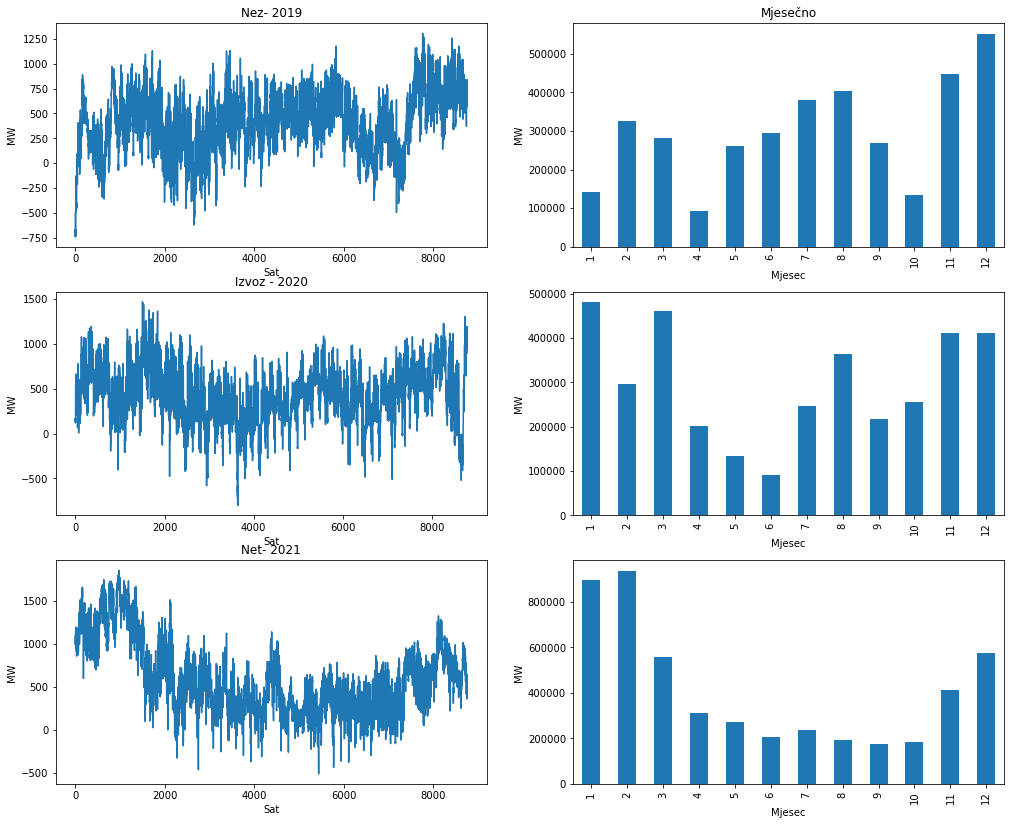

In [289]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(17,14))


net_2019["Diff"].plot(kind="line",stacked=False,ax=ax[0,0])
net_2019.groupby("Month")["Diff"].sum().plot(kind="bar",ax=ax[0,1])

ax[0,0].set_title("Nez- 2019")
ax[0,0].set_xlabel("Sat")
ax[0,0].set_ylabel("MW")
ax[0,1].set_title("Mjesečno")
ax[0,1].set_xlabel("Mjesec")
ax[0,1].set_ylabel("MW")

net_2020["Diff"].plot(kind="line",stacked=False,ax=ax[1,0])
net_2020.groupby("Month")["Diff"].sum().plot(kind="bar",ax=ax[1,1])
ax[1,0].set_title("Izvoz - 2020")
ax[1,0].set_xlabel("Sat")
ax[1,0].set_ylabel("MW")
ax[1,1].set_xlabel("Mjesec")
ax[1,1].set_ylabel("MW")

net_2021["Diff"].plot(kind="line",stacked=False,ax=ax[2,0])
net_2021.groupby("Month")["Diff"].sum().plot(kind="bar",ax=ax[2,1])
ax[2,0].set_title("Net- 2021")
ax[2,0].set_xlabel("Sat")
ax[2,0].set_ylabel("MW")
ax[2,1].set_xlabel("Mjesec")
ax[2,1].set_ylabel("MW")



In [290]:
print("\nMaksimalna razlika izvoz - uvoz 2019., MW\n",net_2019[net_2019["Diff"]==net_2019["Diff"].max()])
print("\nMaksimalna razlika izvoz - uvoz 2020., MW\n",net_2020[net_2020["Diff"]==net_2020["Diff"].max()])
print("\nMaksimalna razlika izvoz - uvoz 2021., MW\n",net_2021[net_2021["Diff"]==net_2021["Diff"].max()])


Maksimalna razlika izvoz - uvoz 2019., MW
       Month  Import  Export    Diff
7763     11    18.0  1323.0  1305.0

Maksimalna razlika izvoz - uvoz 2020., MW
       Month  Import  Export    Diff
1506      3     8.0  1477.0  1469.0

Maksimalna razlika izvoz - uvoz 2021., MW
      Month  Import  Export    Diff
979      2    64.0  1919.0  1855.0


In [291]:
print("\nMaksimalni izvoz - 2019., MW\n",net_2019[net_2019['Export']==net_2019['Export'].max()])
print("\nMaksimalni izvoz - 2020., MW\n",net_2020[net_2020['Export']==net_2020['Export'].max()])
print("\nMaksimalni izvoz - 2021., MW\n",net_2021[net_2021['Export']==net_2021['Export'].max()])


Maksimalni izvoz - 2019., MW
       Month  Import  Export   Diff
1856      3   705.0  1626.0  921.0

Maksimalni izvoz - 2020., MW
       Month  Import  Export    Diff
2138      3   554.0  1678.0  1124.0

Maksimalni izvoz - 2021., MW
      Month  Import  Export    Diff
827      2   254.0  1944.0  1690.0


In [292]:
print("\nMaksimalni izvoz - 2019., MW\n",net_2019[net_2019['Import']==net_2019['Import'].max()])
print("\nMaksimalni izvoz - 2020., MW\n",net_2020[net_2020['Import']==net_2020['Import'].max()])
print("\nMaksimalni izvoz - 2021., MW\n",net_2021[net_2021['Import']==net_2021['Import'].max()])


Maksimalni izvoz - 2019., MW
       Month  Import  Export   Diff
2678      4  1097.0   833.0 -264.0

Maksimalni izvoz - 2020., MW
       Month  Import  Export   Diff
8650     12  1276.0   788.0 -488.0

Maksimalni izvoz - 2021., MW
       Month  Import  Export   Diff
3925      6  1188.0   840.0 -348.0


# Priprema fajlova za EnergyPLAN

## Demand side

Za proračun je poslužila slika sa 2.1 pisanog dijela. 

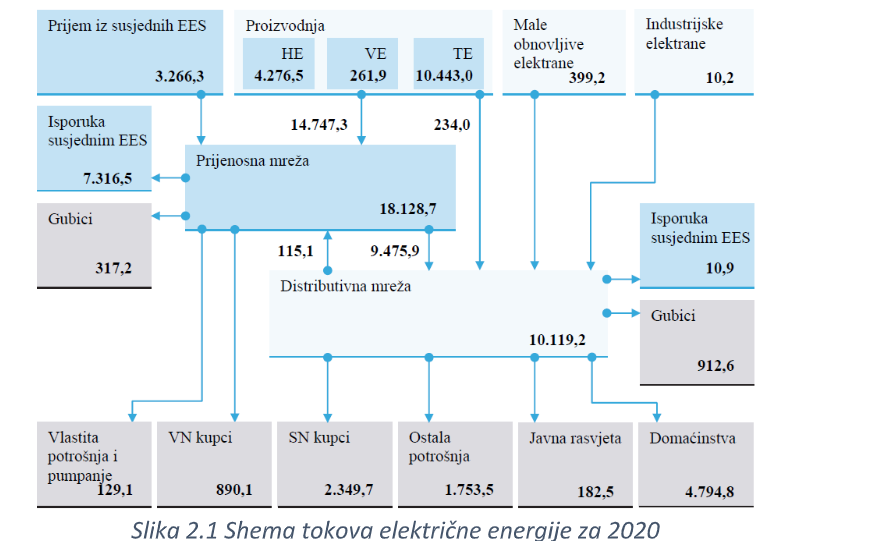

Tzv. "Demand side" bez gubitaka,TWh/god:

In [293]:
print("Potrošnja 2018.:",file3_2018["Konzum, MWh"].sum(axis=0)/1000000)#treba downloadovati uvoz/izvoz za 2018.

print("Potrošnja 2019.:",(file3_2019["Konzum, MWh"]).sum(axis=0)/1000000)
print("Potrošnja 2020.:",(file3_2020["Konzum, MWh"]).sum(axis=0)/1000000)

Potrošnja 2018.: 12.063849123999999
Potrošnja 2019.: 11.349038210529999
Potrošnja 2020.: 10.356146615


Prenosni gubici

In [294]:
print("Gubici 2018.:",file3_2018["Gubici, MWh"].sum(axis=0)/1000) #GWh/god

print("Gubici 2019.:",file3_2019["Gubici, MWh"].sum(axis=0)/1000)#GWh/god
print("Gubici 2020.:",file3_2020["Gubici, MWh"].sum(axis=0)/1000)#GWh/god 

Gubici 2018.: 398.61738399999996
Gubici 2019.: 322.06220399999995
Gubici 2020.: 317.03684400000003


Tzv. "Demand side" sa gubicima, TWh/god

In [295]:
print("Potrošnja 2018.:",file3_2018["Gubici + Konzum, MWh"].sum(axis=0)/1000000,"TWh/god")#treba downloadovati uvoz/izvoz za 2018.
print("Potrošnja 2019.:",(file3_2019["Gubici + Konzum, MWh"]).sum(axis=0)/1000000,"TWh/god")
print("Potrošnja 2020.:",(file3_2020["Gubici + Konzum, MWh"]).sum(axis=0)/1000000,"TWh/god")


Potrošnja 2018.: 12.462466508 TWh/god
Potrošnja 2019.: 11.67110041453 TWh/god
Potrošnja 2020.: 10.673183459 TWh/god


Potrebe za električnom energijom za 2020. zajedno sa gubicima prenosa data je iznad. U ovom slučaju nije poznato da li "Konzum" termin obuhvata i VN kupce, te vlastitu potrošnju i pumpanje, te će se validacija napraviti uz pomoć podataka o ukupnim potrebama sa ENTSOe transparency platforme.

In [296]:
actual_load_2019=pd.read_csv(r"FILES\ELEKT\Total Load - Day Ahead _ Actual_2019.csv")
actual_load_2020=pd.read_csv(r"FILES\ELEKT\Total Load - Day Ahead _ Actual_2020.csv")
actual_load_2021=pd.read_csv(r"FILES\ELEKT\Total Load - Day Ahead _ Actual_2021.csv")

In [297]:
actual_load_2019.columns

Index(['Time (UTC)', 'Day-ahead Total Load Forecast [MW] - BZN|BA',
       'Actual Total Load [MW] - BZN|BA'],
      dtype='object')

In [298]:
print("Potrošnja 2019.:",actual_load_2019['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh")
print("Potrošnja 2020.:",actual_load_2020['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh")
print("Potrošnja 2021.:",actual_load_2021['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh")

Potrošnja 2019.: 11.923965 TWh
Potrošnja 2020.: 11.148244 TWh
Potrošnja 2021.: 10.21885 TWh


Primijećeno je da u fajlovima sa ENTSOe platforme ima praznih redova, te će se oni dopuniti sa podacima za isto vrijeme koji su dostupni od NOS-a.

In [300]:
actual_load_2019.loc[actual_load_2019['Actual Total Load [MW] - BZN|BA'].isna(),'Actual Total Load [MW] - BZN|BA']=file3_2019.loc[(actual_load_2019[actual_load_2019['Actual Total Load [MW] - BZN|BA'].isna()].index),"Gubici + Konzum, MWh"]
actual_load_2020.loc[actual_load_2020['Actual Total Load [MW] - BZN|BA'].isna(),'Actual Total Load [MW] - BZN|BA']=file3_2020.loc[(actual_load_2020[actual_load_2020['Actual Total Load [MW] - BZN|BA'].isna()].index),"Gubici + Konzum, MWh"]
#actual_load_2021.loc[actual_load_2021['Actual Total Load [MW] - BZN|BA'].isna(),'Actual Total Load [MW] - BZN|BA']=file3_2021.loc[(actual_load_2021[actual_load_2021['Actual Total Load [MW] - BZN|BA'].isna()].index),"Gubici + Konzum, MWh"]

In [313]:
actual_load_2019.loc[actual_load_2019['Actual Total Load [MW] - BZN|BA']<=0,'Actual Total Load [MW] - BZN|BA']=file3_2019.loc[(actual_load_2019[actual_load_2019['Actual Total Load [MW] - BZN|BA']<=0].index),"Gubici + Konzum, MWh"]
actual_load_2020.loc[actual_load_2020['Actual Total Load [MW] - BZN|BA']<=0,'Actual Total Load [MW] - BZN|BA']=file3_2020.loc[(actual_load_2020[actual_load_2020['Actual Total Load [MW] - BZN|BA']<=0].index),"Gubici + Konzum, MWh"]

In [314]:
print("Potrošnja 2019.:",actual_load_2019['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh")
print("Potrošnja 2020.:",actual_load_2020['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh")
print("Potrošnja 2021.:",actual_load_2021['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh")

Potrošnja 2019.: 12.020241901079999 TWh
Potrošnja 2020.: 11.371931204 TWh
Potrošnja 2021.: 10.21885 TWh


Softver dozovljava samo unos 8784 satnih podataka, te će se za godine u kojima je broj sati 8760 dodati 24 nule kako bi ulazni podaci unijeli bez prepreka.

In [315]:
zeros = pd.DataFrame(0, index=np.arange(24),columns=file3_2018.columns)
file3_2018= pd.concat([file3_2018, zeros])
file3_2019= pd.concat([file3_2019, zeros])
actual_load_2019= pd.concat([actual_load_2019, zeros])
actual_load_2021= pd.concat([actual_load_2021, zeros])
print("8784 vrijednosti, zadnjih 24 su nule")



8784 vrijednosti, zadnjih 24 su nule


In [316]:
pd.to_numeric(file3_2018["Gubici + Konzum, MWh"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\el_demandBH_2018.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(file3_2019["Gubici + Konzum, MWh"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\el_demandBH_2019.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(file3_2020["Gubici + Konzum, MWh"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\el_demandBH_2020.txt', index=False,header=0,decimal=",",sep=" ")

In [317]:
pd.to_numeric(actual_load_2019['Actual Total Load [MW] - BZN|BA']).to_csv(r'EnergyPLAN files\Electricity\Hourly\Actual_load_2019_BH.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(actual_load_2020['Actual Total Load [MW] - BZN|BA']).to_csv(r'EnergyPLAN files\Electricity\Hourly\Actual_load_2020_BH.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(actual_load_2021['Actual Total Load [MW] - BZN|BA']).to_csv(r'EnergyPLAN files\Electricity\Hourly\Actual_load_2021_BH.txt', index=False,header=0,decimal=",",sep=" ")

In [318]:
actual_load_2020['Actual Total Load [MW] - BZN|BA'].sum()/1000000

11.371931204

S obzirom da podaci od ENTSOe sadrže nule, i prazna mjesta, kao finalni će se upotrebljavati podaci od NOS BiH:

In [319]:
print("Potrošnja 2018.:",file3_2018["Gubici + Konzum, MWh"].sum(axis=0)/1000000,"TWh/god")#treba downloadovati uvoz/izvoz za 2018.
print("Potrošnja 2019.:",(file3_2019["Gubici + Konzum, MWh"]).sum(axis=0)/1000000,"TWh/god")
print("Potrošnja 2020.:",(file3_2020["Gubici + Konzum, MWh"]).sum(axis=0)/1000000,"TWh/god")


Potrošnja 2018.: 12.462466508 TWh/god
Potrošnja 2019.: 11.67110041453 TWh/god
Potrošnja 2020.: 10.673183459 TWh/god


### Uvoz/izvoz

In [306]:

print("Uvoz 2019.:",net_2019['Import'].sum(axis=0)/1000,"GWh/god")#GWh/god
print("Uvoz 2020.:",net_2020['Import'].sum(axis=0)/1000, "GWh/god")#GWh/god

Uvoz 2019.: 1518.111 GWh/god
Uvoz 2020.: 2156.444 GWh/god


In [307]:
print("Izvoz 2019.:",net_2019['Export'].sum(axis=0)/1000,"GWh/god")#GWh/god
print("Izvoz 2020.:",net_2020['Export'].sum(axis=0)/1000,"GWh/god")#GWh/god

Izvoz 2019.: 5099.52 GWh/god
Izvoz 2020.: 5728.87 GWh/god


Pošto se za ovu stavku navodi fixed import/ export, napraviti će se razlika kao "Izvoz" - "Uvoz". Ponovo nije potrebno izvršiti pretvaranje jedinica jer će softver normalizirati vrijednosti prema maksimalnoj u distribuciji.

In [308]:
net_2019=net_2019.assign(Diff_en_pl=net_2019['Export'].sub(net_2019['Import']))
net_2020=net_2020.assign(Diff_en_pl=net_2020['Export'].sub(net_2020['Import']))
net_2021=net_2021.assign(Diff_en_pl=net_2021['Export'].sub(net_2021['Import']))

Za razliku od narednog podatka, NOS BiH izvještava da ostvareni fizički tokovi električne energije na interkonektivnim dalekovodima u 2020. godini, daju saldo razmijenjene električne energije regulacionog područja BiH u iznosu od 4.050 GWh  u smjeru izvoza. Na slici 2.1. se može vidjeti da su i uvoz i izvoz električne energije koji izvještava NOSBiH manji nego što izvještava ENTSOe.

In [309]:
print("Imp/Exp 2019.:",net_2019["Diff_en_pl"].sum(axis=0)/1000000)
print("Imp/Exp 2020.:",net_2020["Diff_en_pl"].sum(axis=0)/1000000)
print("Imp/Exp 2021.:",net_2021["Diff_en_pl"].sum(axis=0)/1000000)


Imp/Exp 2019.: 3.581409
Imp/Exp 2020.: 3.572426
Imp/Exp 2021.: 4.961745


In [310]:
zeros = pd.DataFrame(0, index=np.arange(24),columns=net_2019.columns)
net_2019= pd.concat([net_2019, zeros])
net_2021= pd.concat([net_2021, zeros])
print("8784 vrijednosti, zadnjih 24 su nule")

8784 vrijednosti, zadnjih 24 su nule


In [311]:
pd.to_numeric(net_2019["Diff_en_pl"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\fix_imp_expBH_2019.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(net_2020["Diff_en_pl"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\fix_imp_expBH_2020.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(net_2021["Diff_en_pl"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\fix_imp_expBH_2021.txt', index=False,header=0,decimal=",",sep=" ")

Napomena: Ovdje se mogu i preuzeti podaci za 2018. sa ENTSO portala i spasiti istom procedurom ako je potrebno. Model se trenutno počeo praviti za 2020. godinu (ili će se to učiniti za 2019. ukoliko ne bude drugih podataka). Očekuje se da će statistički podaci biti u međuvremenu objavljeni za 2020. te se radi toga izabrala ova godina.

Ulazni podaci:

In [312]:
print("Potrošnja 2020.:",actual_load_2020['Actual Total Load [MW] - BZN|BA'].sum(axis=0)/1000000,"TWh/god") #electricity demand
#print("Additional electricty demand:",(129.1+890.1+912.6)/1000,"TWh/god")
print("Imp/Exp 2020.:",net_2020["Diff_en_pl"].sum(axis=0)/1000000,"TWh/god")#fixed import export

Potrošnja 2020.: 11.313462387 TWh/god
Imp/Exp 2020.: 3.572426 TWh/god


Dalje treba razmotriti potrošnju el. energije za hlađenje i grijanje....

### Transmission line capacity

Za maksimalni kapacitet prekograničnih tokova ( na što se odnosi Transmission line capacity) morali bi biti poznate snage svih transformatora za interkonkecije. Također, kapacitet prenosnih linija zavisi od mogućnosti snage koji jedan TSO može primiti ili predati. Ovaj podatak se može dobiti na  https://www.nosbih.ba/bs/kapaciteti/ntc/ Dok se ne preuzmu podaci sa NOS BiH, iskoristiti će se podaci prognoza sa ENTSOe 

The purpose is to make it possible for one country/system to assist in the balancing of another
country/system, e.g. to use the flexibility of Norwegian hydropower to balance a Swedish, Danish or
European system.
Using the feature requires an hourly distribution file, which can have both negative and positive
numbers:
- Positive numbers means a request for export out of the internal system (i.e. import into the
external system)
- Negative numbers means a request for the opposite

In [ ]:
predictions_2019_HR=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2019HR.csv")
predictions_2019_RS=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2019RS.csv")
predictions_2019_ME=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2019ME.csv")

predictions_2020_HR=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2020HR.csv")
predictions_2020_RS=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2020RS.csv")
predictions_2020_ME=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2020ME.csv")

predictions_2021_HR=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2021HR.csv")
predictions_2021_RS=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2021RS.csv")
predictions_2021_ME=pd.read_csv(r"FILES\ELEKT\FORECAST\Forecasted Transfer Capacities - Day Ahead_2021ME.csv")


In [ ]:
predictions_2019_HR[['BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]']] =predictions_2019_RS[['BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]']].values
predictions_2019_HR[['BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]']] =predictions_2019_ME[['BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]']].values

In [ ]:
predictions_2020_HR[['BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]']] =predictions_2020_RS[['BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]']].values
predictions_2020_HR[['BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]']] =predictions_2020_ME[['BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]']].values

In [ ]:
predictions_2021_HR[['BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]']] =predictions_2021_RS[['BZN|RS > BZN|BA [MW]', 'BZN|BA > BZN|RS [MW]']].values
predictions_2021_HR[['BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]']] =predictions_2021_ME[['BZN|ME > BZN|BA [MW]', 'BZN|BA > BZN|ME [MW]']].values

In [ ]:
predictions_2019_HR.head(3)

In [ ]:
predictions_2019=predictions_2019_HR
predictions_2020=predictions_2020_HR
predictions_2021=predictions_2021_HR

In [ ]:
predictions_2019=predictions_2019.assign(Timestamp=pd.date_range("2019-01-01 00:00:00","2020-01-01", freq="1H"))
predictions_2020=predictions_2020.assign(Timestamp=pd.date_range("2020-01-01 00:00:00","2021-01-01", freq="1H"))
predictions_2021=predictions_2021.assign(Timestamp=pd.date_range("2021-01-01 00:00:00","2022-01-01", freq="1H"))

In [ ]:
#file=file.set_index(file['Timestamp'].astype('datetime64[ns]'))
predictions_2019["Month"],predictions_2020["Month"],predictions_2021["Month"]=predictions_2019["Timestamp"].dt.month,predictions_2020["Timestamp"].dt.month,predictions_2021["Timestamp"].dt.month
predictions_2019["Year"],predictions_2020["Year"],predictions_2021["Year"]=predictions_2019["Timestamp"].dt.year,predictions_2020["Timestamp"].dt.year,predictions_2021["Timestamp"].dt.year
predictions_2019["Day"],predictions_2020["Day"],predictions_2021["Day"]=predictions_2019["Timestamp"].dt.day,predictions_2020["Timestamp"].dt.day,predictions_2021["Timestamp"].dt.day
predictions_2019["Hour"],predictions_2020["Hour"],predictions_2021["Hour"]=predictions_2019["Timestamp"].dt.hour,predictions_2020["Timestamp"].dt.hour,predictions_2021["Timestamp"].dt.hour

In [ ]:
predictions_2019.columns

In [ ]:
predictions_2019["Forecasted import"]=predictions_2019[['BZN|HR > BZN|BA [MW]','BZN|RS > BZN|BA [MW]','BZN|ME > BZN|BA [MW]']].sum(axis=1)
predictions_2020["Forecasted import"]=predictions_2020[['BZN|HR > BZN|BA [MW]','BZN|RS > BZN|BA [MW]','BZN|ME > BZN|BA [MW]']].sum(axis=1)
predictions_2021["Forecasted import"]=predictions_2021[['BZN|HR > BZN|BA [MW]','BZN|RS > BZN|BA [MW]','BZN|ME > BZN|BA [MW]']].sum(axis=1)

In [ ]:
predictions_2019["Forecasted export"]=predictions_2019[['BZN|BA > BZN|HR [MW]','BZN|BA > BZN|RS [MW]','BZN|BA > BZN|ME [MW]']].sum(axis=1)
predictions_2020["Forecasted export"]=predictions_2020[['BZN|BA > BZN|HR [MW]','BZN|BA > BZN|RS [MW]','BZN|BA > BZN|ME [MW]']].sum(axis=1)
predictions_2021["Forecasted export"]=predictions_2021[['BZN|BA > BZN|HR [MW]','BZN|BA > BZN|RS [MW]','BZN|BA > BZN|ME [MW]']].sum(axis=1)

Kapacitet prekograničnih linija će se staviti da je 2500 MW na osnovu maksimalno mogućeg uvoza/izvoza u jednom satu.

In [ ]:
print("Maksimalno prognozirani uvoz u jednom satu 2019:",predictions_2019["Forecasted import"].max(),"MW")
print("Maksimalno prognozirani izvoz u jednom satu 2019:",predictions_2019["Forecasted export"].max(),"MW")

print("Maksimalno prognozirani uvoz u jednom satu 2020:",predictions_2020["Forecasted import"].max(),"MW")
print("Maksimalno prognozirani izvoz u jednom satu 2020:",predictions_2020["Forecasted export"].max(),"MW")

print("Maksimalno prognozirani uvoz u jednom satu 2021:",predictions_2021["Forecasted import"].max(),"MW")
print("Maksimalno prognozirani izvoz u jednom satu 2021:",predictions_2021["Forecasted export"].max(),"MW")

In [ ]:
predictions_2019[['BZN|HR > BZN|BA [MW]','BZN|RS > BZN|BA [MW]','BZN|ME > BZN|BA [MW]']].plot()

In [ ]:
predictions_2019[['BZN|BA > BZN|HR [MW]','BZN|BA > BZN|RS [MW]','BZN|BA > BZN|ME [MW]']].plot()

In [ ]:
pd.to_numeric(predictions_2019["Forecasted net"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\forecast_imp_expBH_2019.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(predictions_2020["Forecasted net"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\forecast_imp_expBH_2020.txt', index=False,header=0,decimal=",",sep=" ")
pd.to_numeric(predictions_2021["Forecasted net"]).to_csv(r'EnergyPLAN files\Electricity\Hourly\forecast_imp_expBH_2021.txt', index=False,header=0,decimal=",",sep=" ")

# Reference

<br>https://www.nosbih.ba/bs/ees/graf-potrosnje/
<br>https://transparency.entsoe.eu/dashboard/show
<br>https://www.entsoe.eu/data/